In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
    
import glob
from tqdm import tqdm  # progress bar

In [3]:
step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "CTCGAGATAACTTCGTATAATGTATGCTAT",
                       post = "GGCCGGCCATAGGGCCCC",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "GAGCTCGCTAGC",
                       post = "CTCGAGATAA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GGCCGGCCATAGGGCCCC",
                       post = "GCGGTCCA",
                       length = 16)

step1_AD = finder.Barcode(name = "AD",
                       preceder = "CACCATG",
                       post = "GGATCCG",
                       length = 162)

In [4]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full-clustered.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 10,
                        map_order = ['grouped', 'barcode_exists', 'thresholded', 'unique_target', 'quality_designed'],
                        step_name = "step1",
                                should_check_exists = True, plot_histograms = True,
                                min_fraction = 0.9,
                                descriptor = "adjacency_corrected")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_adjacency_corrected_

Using the following step order:
1. initial
2. grouped
3. barcode_exists
4. thresholded
5. unique_target
6. quality_designed



# Refining clustered

In [63]:
refiner.load_csv("../../data/NKX2-2_grouped_adjacency_corrected.csv", 'grouped')

Reading CSV from ../../data/NKX2-2_grouped_adjacency_corrected.csv into step1_ADBC2_HawkBCs_RTBC_AD_initial_grouped...
Done in 0.93 seconds.



Grouping step1_ADBC2_HawkBCs_RTBC_AD_initial...
Skipping — table step1_ADBC2_HawkBCs_RTBC_AD_initial_grouped already exists and is initial/grouped.


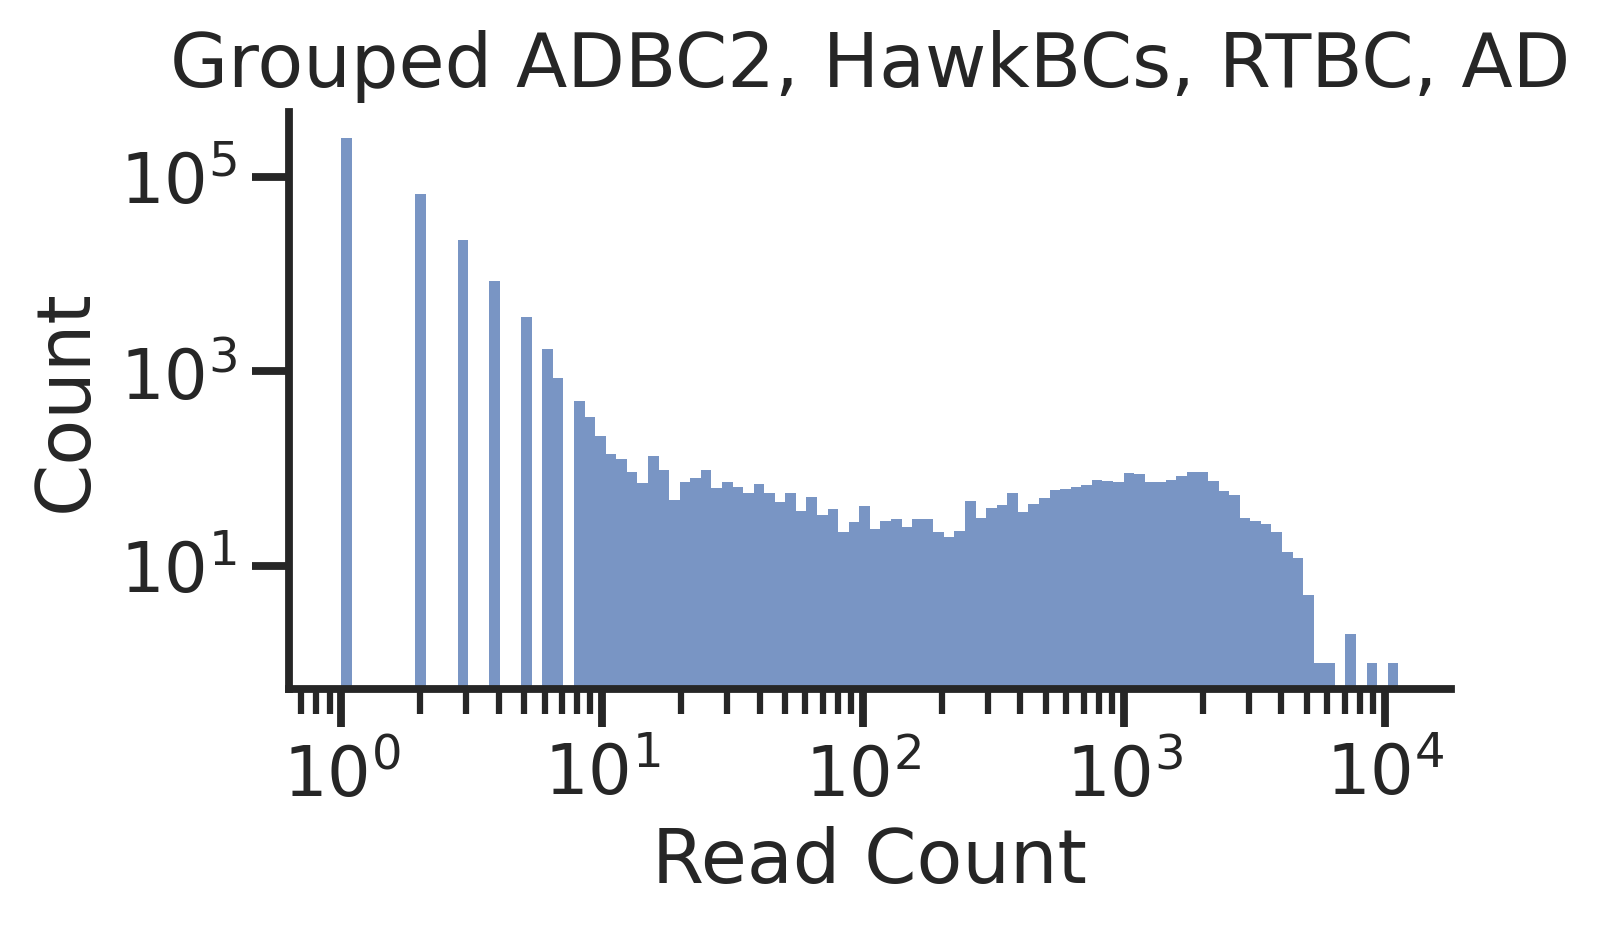

Done in 0.71 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.39 seconds.

Thresholding...
Using reads threshold of 10.


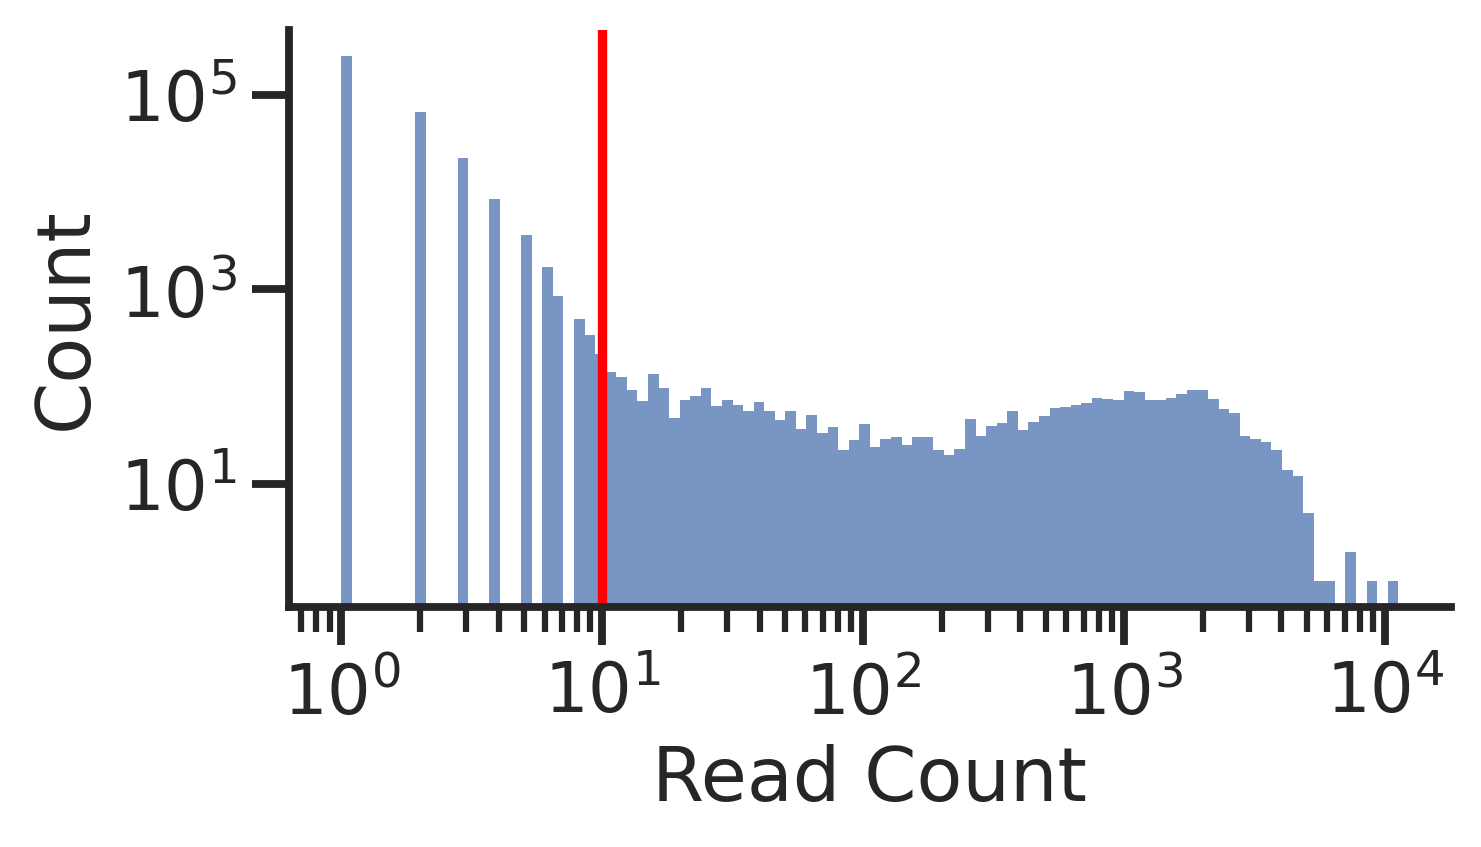

Done in 0.72 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_adjacency_corrected_unique_target
Done in 0.04 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


In [64]:
refiner.refine_map_from_db()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_adjacency_corrected_loss_summary'
Done in 0.07 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_adjacency_corrected_loss_summary'
Done in 0.07 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

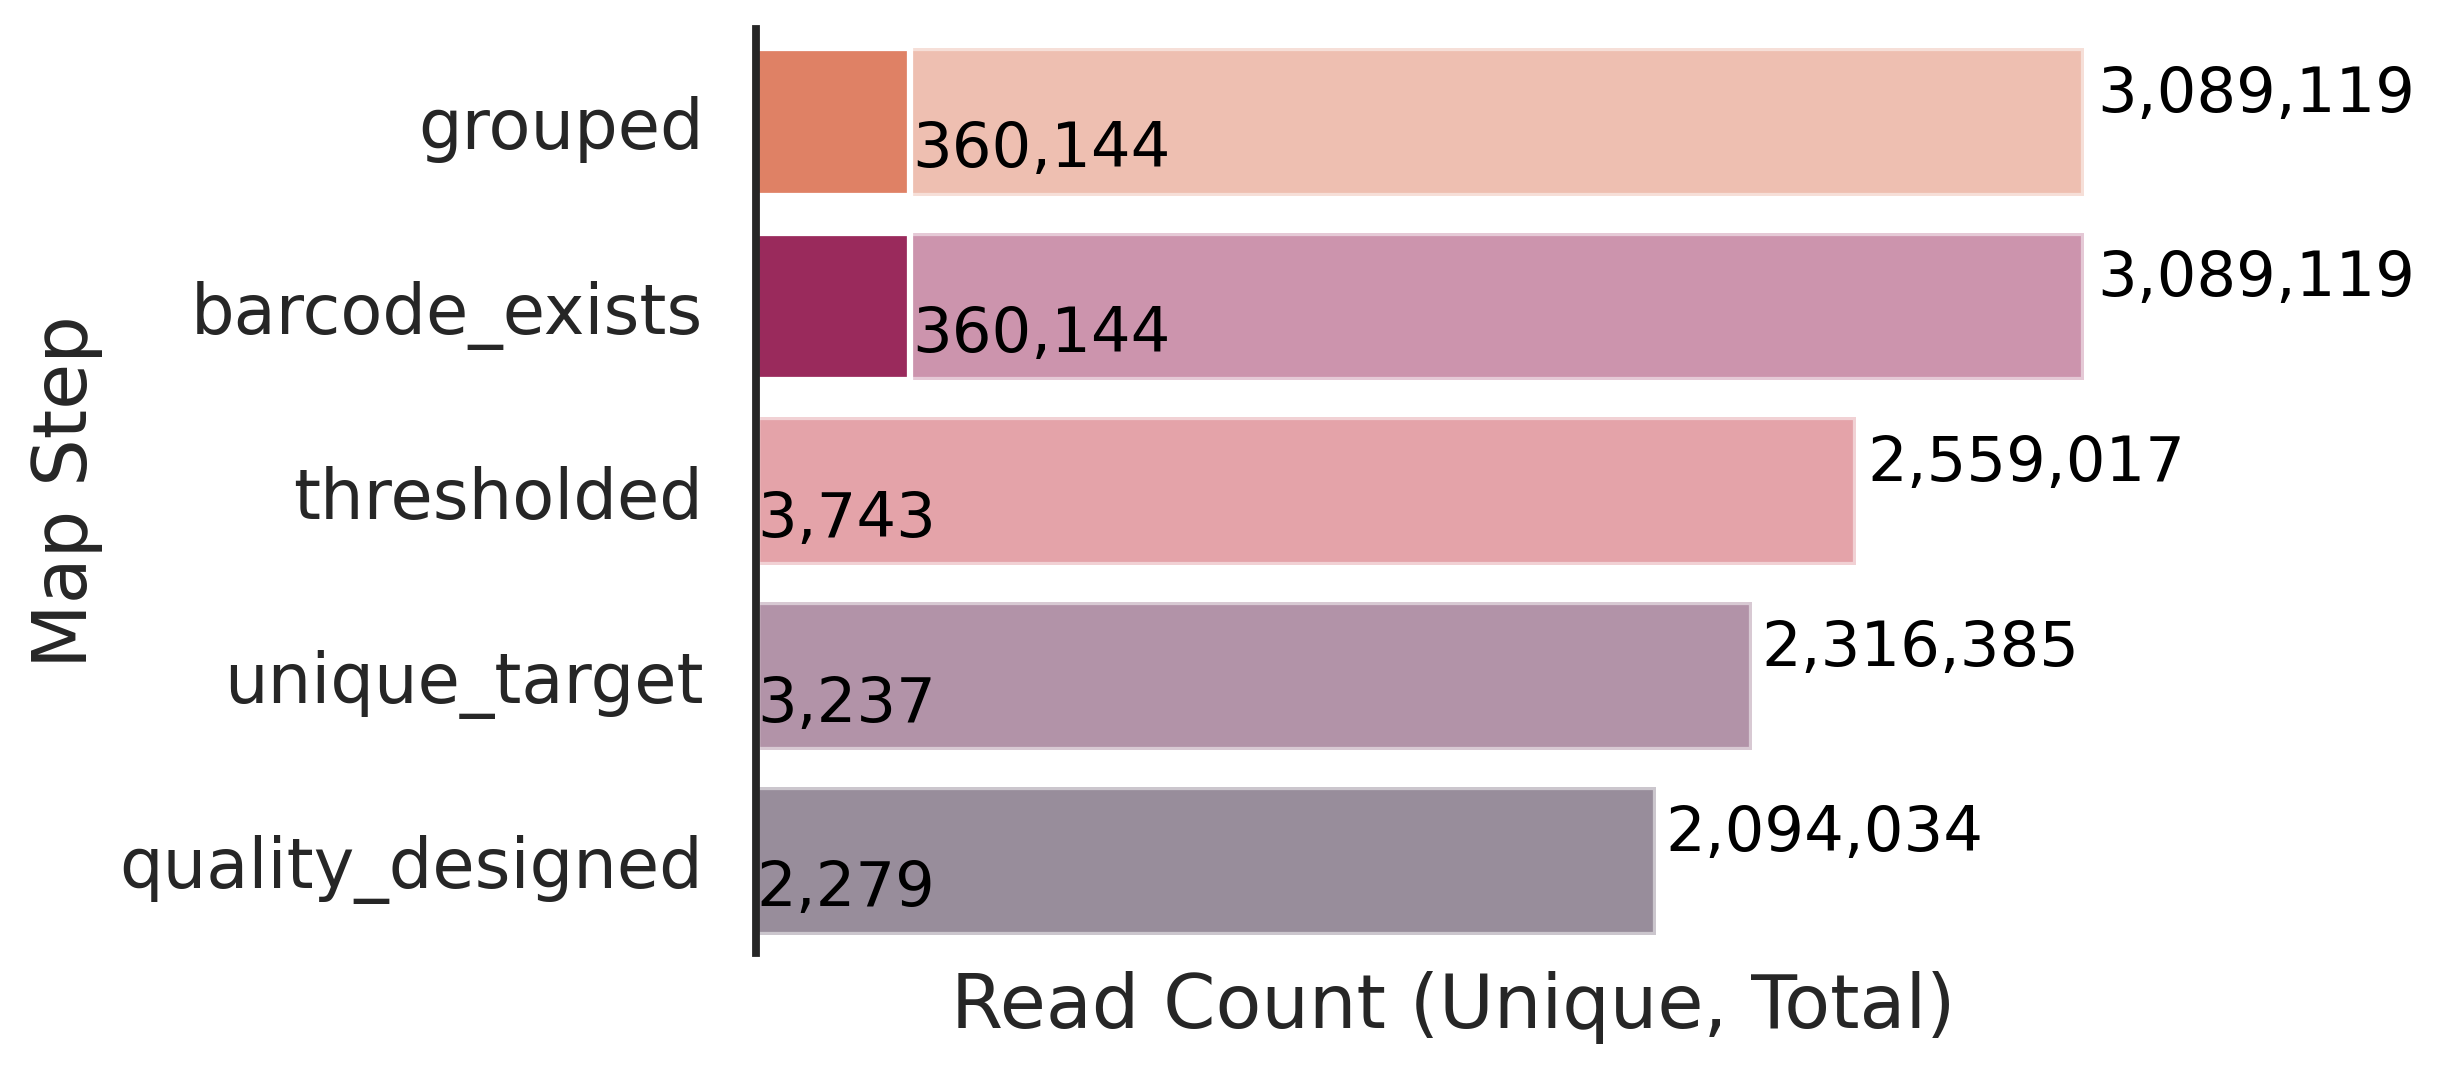

In [65]:
refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

In [6]:
SK_adjacency_clustered_step1_map = refiner.get_map_df('quality_designed')
SK_adjacency_clustered_step1_map.to_csv("../../output/NKX2-2_SK_adjacency_clustered_step1_map.csv")
SK_adjacency_clustered_step1_map

,column00,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed
0,343,AAAAAA,ATTCTCGCC,CTGGAATGACATAGGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,1232,True,True,True,True,1
1,1767,AAAACC,ACCTATCAC,GATTATTGGTGCTATG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,759,True,True,True,True,1
2,3880,AAAATA,AGAGGAGTT,ATAAGCTAAATGCGTA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1923,True,True,True,True,1
3,10714,AAATAC,CCATCGGTT,AAATGTAGGAAAGCTG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,2320,True,True,True,True,1
4,16485,AACAAA,CCGATCTAT,TGCTGAGTGTCGAATT,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,3694,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...
2274,342431,TTAGCA,ACAAGCCAC,TAATTACACCAATGTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,415,True,True,True,True,1
2275,346778,TTCCTA,CATCCACTA,GGTTTGTTACCATTTA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,479,True,True,True,True,1
2276,346941,TTCGAC,AACACTTGG,TAATGTATAAAGATAG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1992,True,True,True,True,1
2277,358350,TTTGCT,AAGACATCG,ACACTATATCGGTGAA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,623,True,True,True,True,1


# Compare to before clustering

In [9]:
refiner_no_cluster = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 10,
                        map_order = ['barcode_exists', 'grouped', 'thresholded', 'unique_target', 'quality_designed'],
                        step_name = "step1",
                                should_check_exists = False, plot_histograms = False,
                                min_fraction = 0.9,
                                descriptor = "overlap_prop")

refiner_no_cluster

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. barcode_exists
3. grouped
4. thresholded
5. unique_target
6. quality_designed



In [10]:
refiner_no_cluster.refine_map_from_db()

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.50 seconds.

Grouping step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_barcode_exists...
Done in 0.72 seconds.

Thresholding...
Using reads threshold of 10.
Done in 0.01 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_unique_target
Done in 0.05 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.09 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

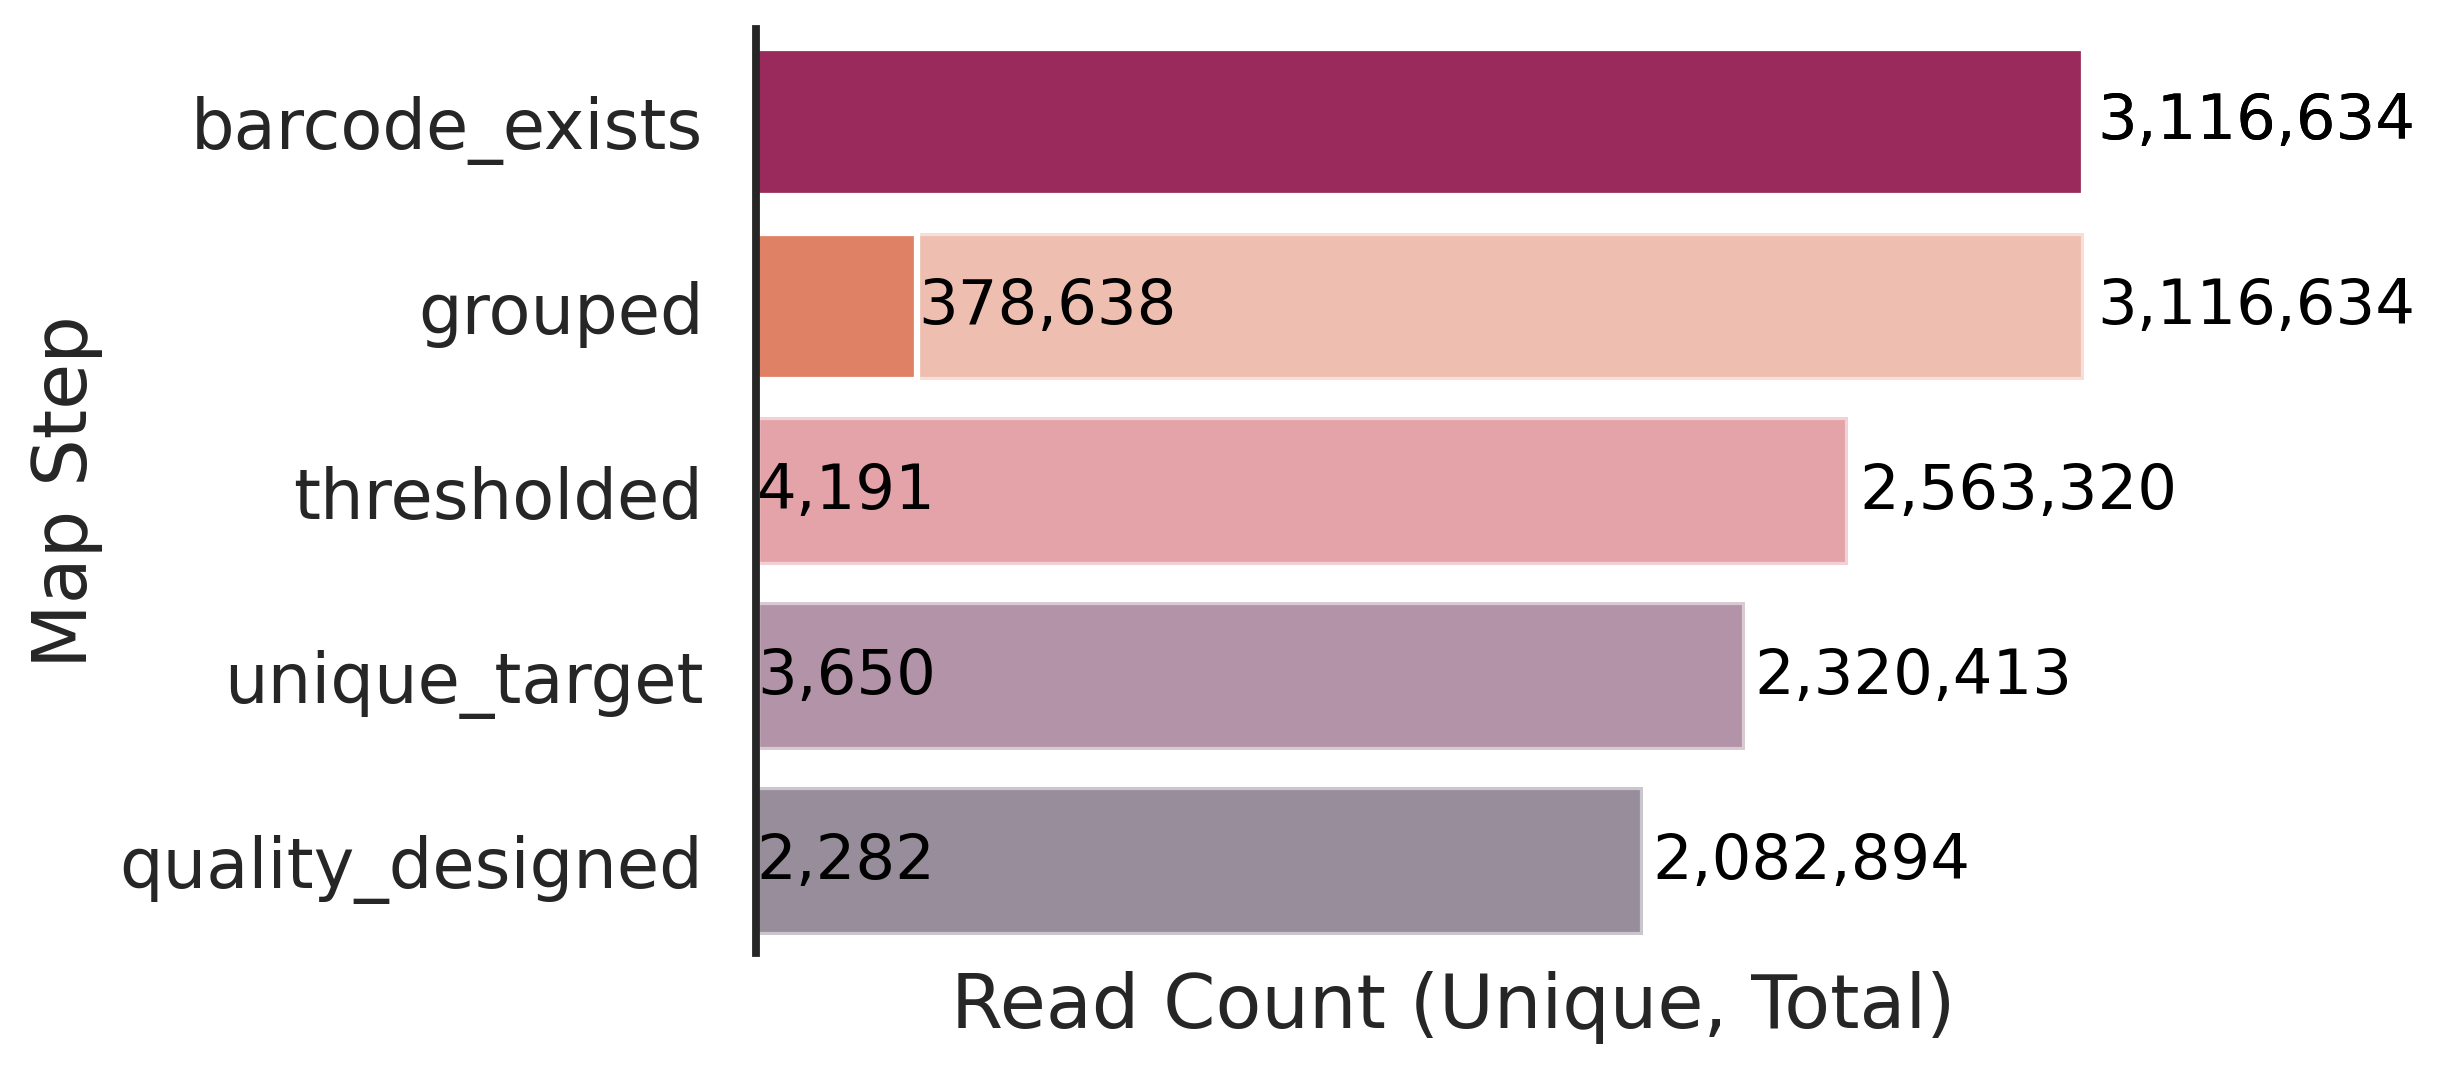

In [11]:
refiner_no_cluster.plot_loss()

In [81]:
# How do reads per AD , ADBC(s), and RPTR BCs compare?

In [127]:
def plot_summed_counts(refiner, group_cols, step_name, count_col="count", ax=None, xlabel=None, ylabel="Frequency", label=None, add_counts = False):
    # Get dataframe
    df = refiner.get_map_df(step_name).copy()
    
    # Sum counts per group
    summed_counts = df.groupby(group_cols)[count_col].sum().reset_index(name="summed_count")
    display(sum(summed_counts["summed_count"]))

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    max_count = summed_counts["summed_count"].max()

    sns.histplot(data=summed_counts, x="summed_count", ax=ax, label=label,log_scale = (True, True), edgecolor = 'none', alpha = 0.7, bins = 100)
    # ax.axvline(np.mean(summed_counts["summed_count"]))

    if add_counts:
        # Add counts on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(
                    p.get_x() + p.get_width()/2,
                    height + 0.05,
                    int(height),
                    ha='center',
                    va='bottom'
                )
    
        # Make x-axis ticks discrete
        ax.set_xticks(np.arange(0, max_count + 1, 1))
    
        ax.set_xlabel(xlabel or "Summed Count per Group")
        ax.set_ylabel(ylabel)
        if label:
            ax.legend()
    sns.despine()
    return ax

3116634

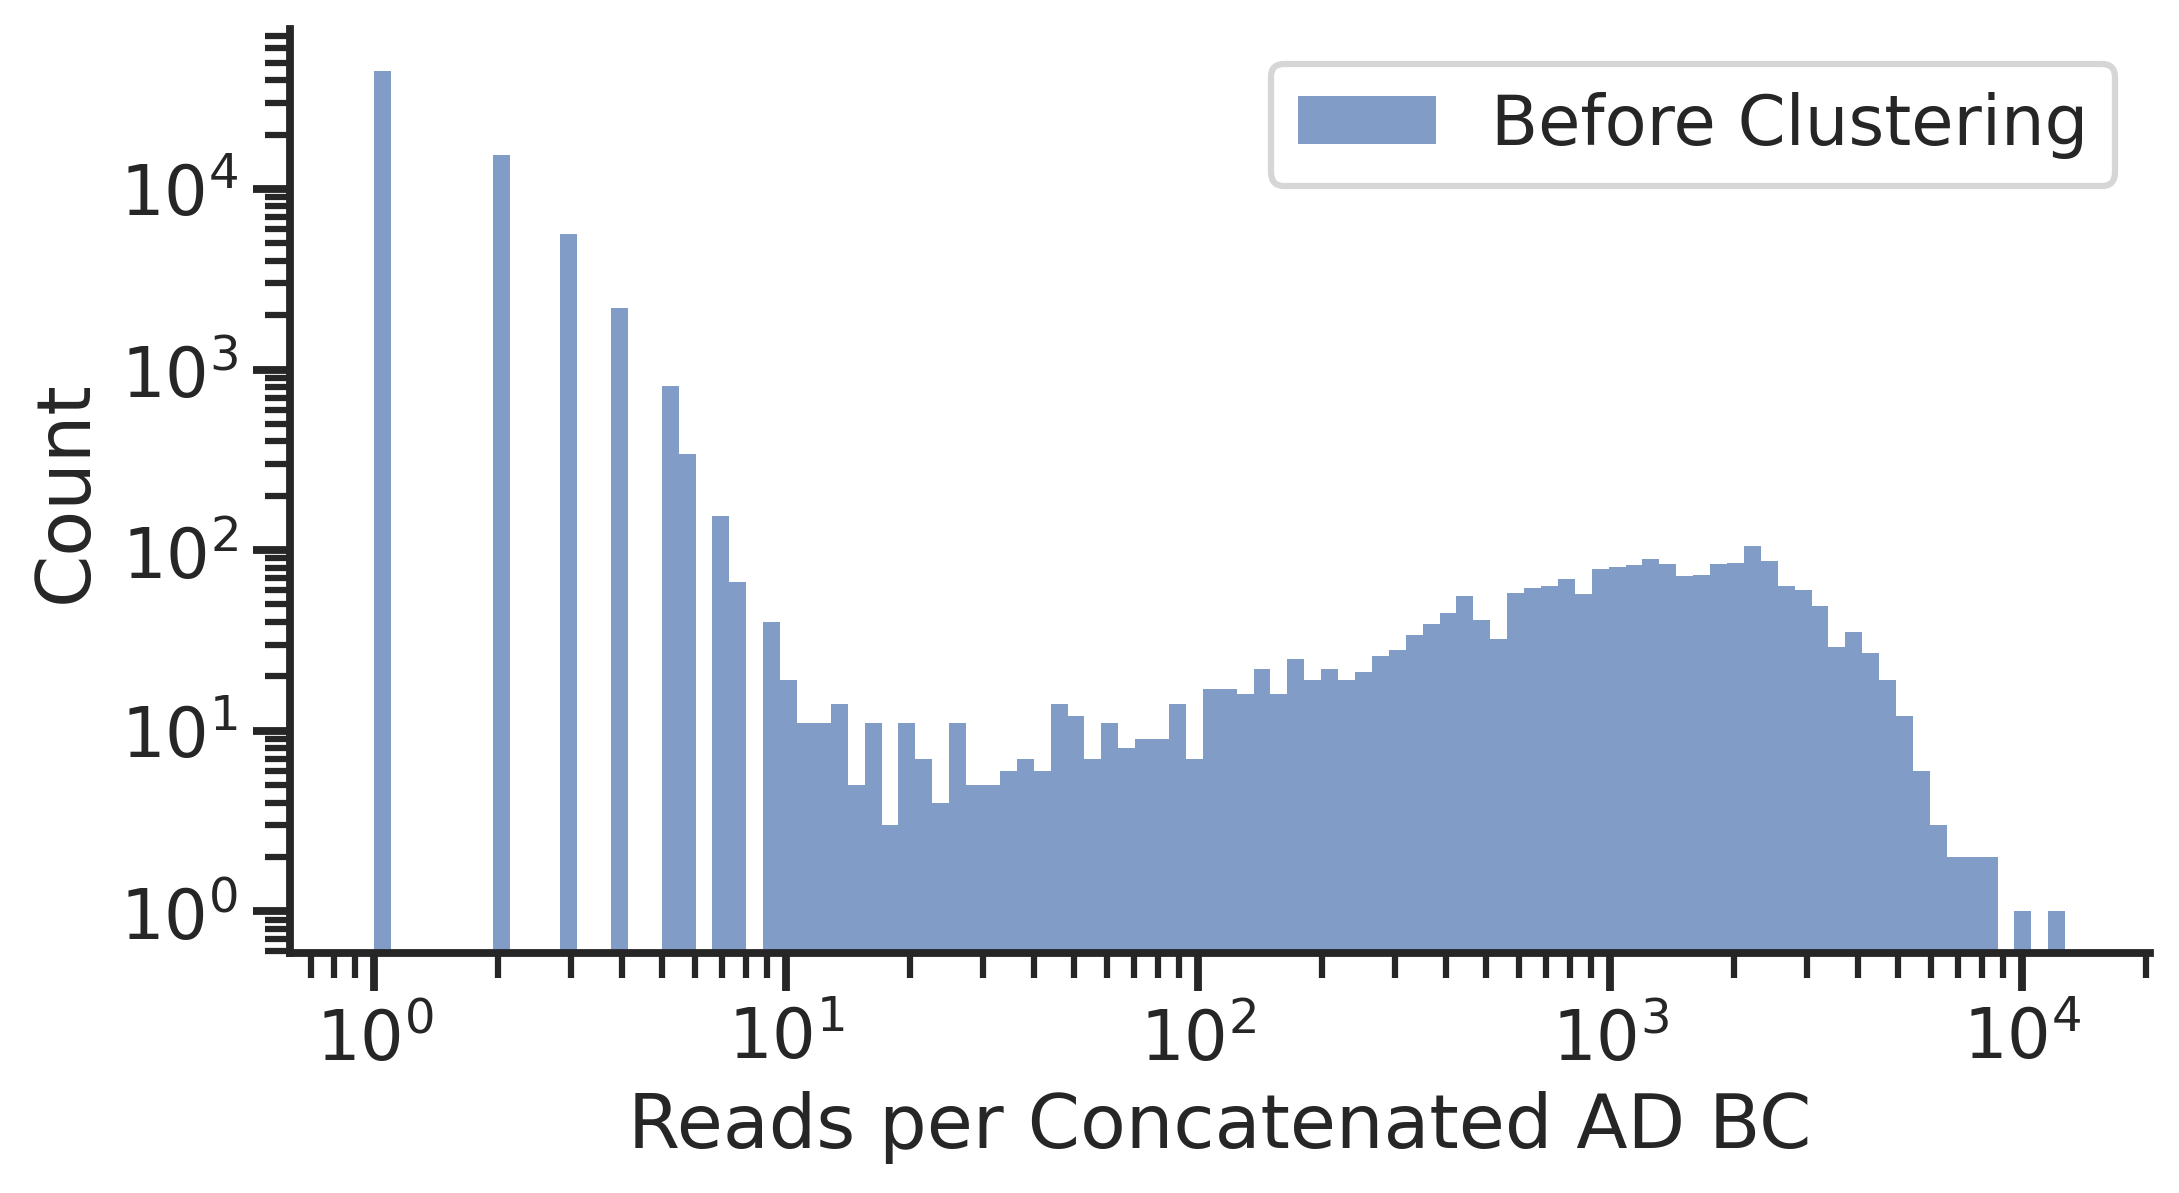

3116634

3089119

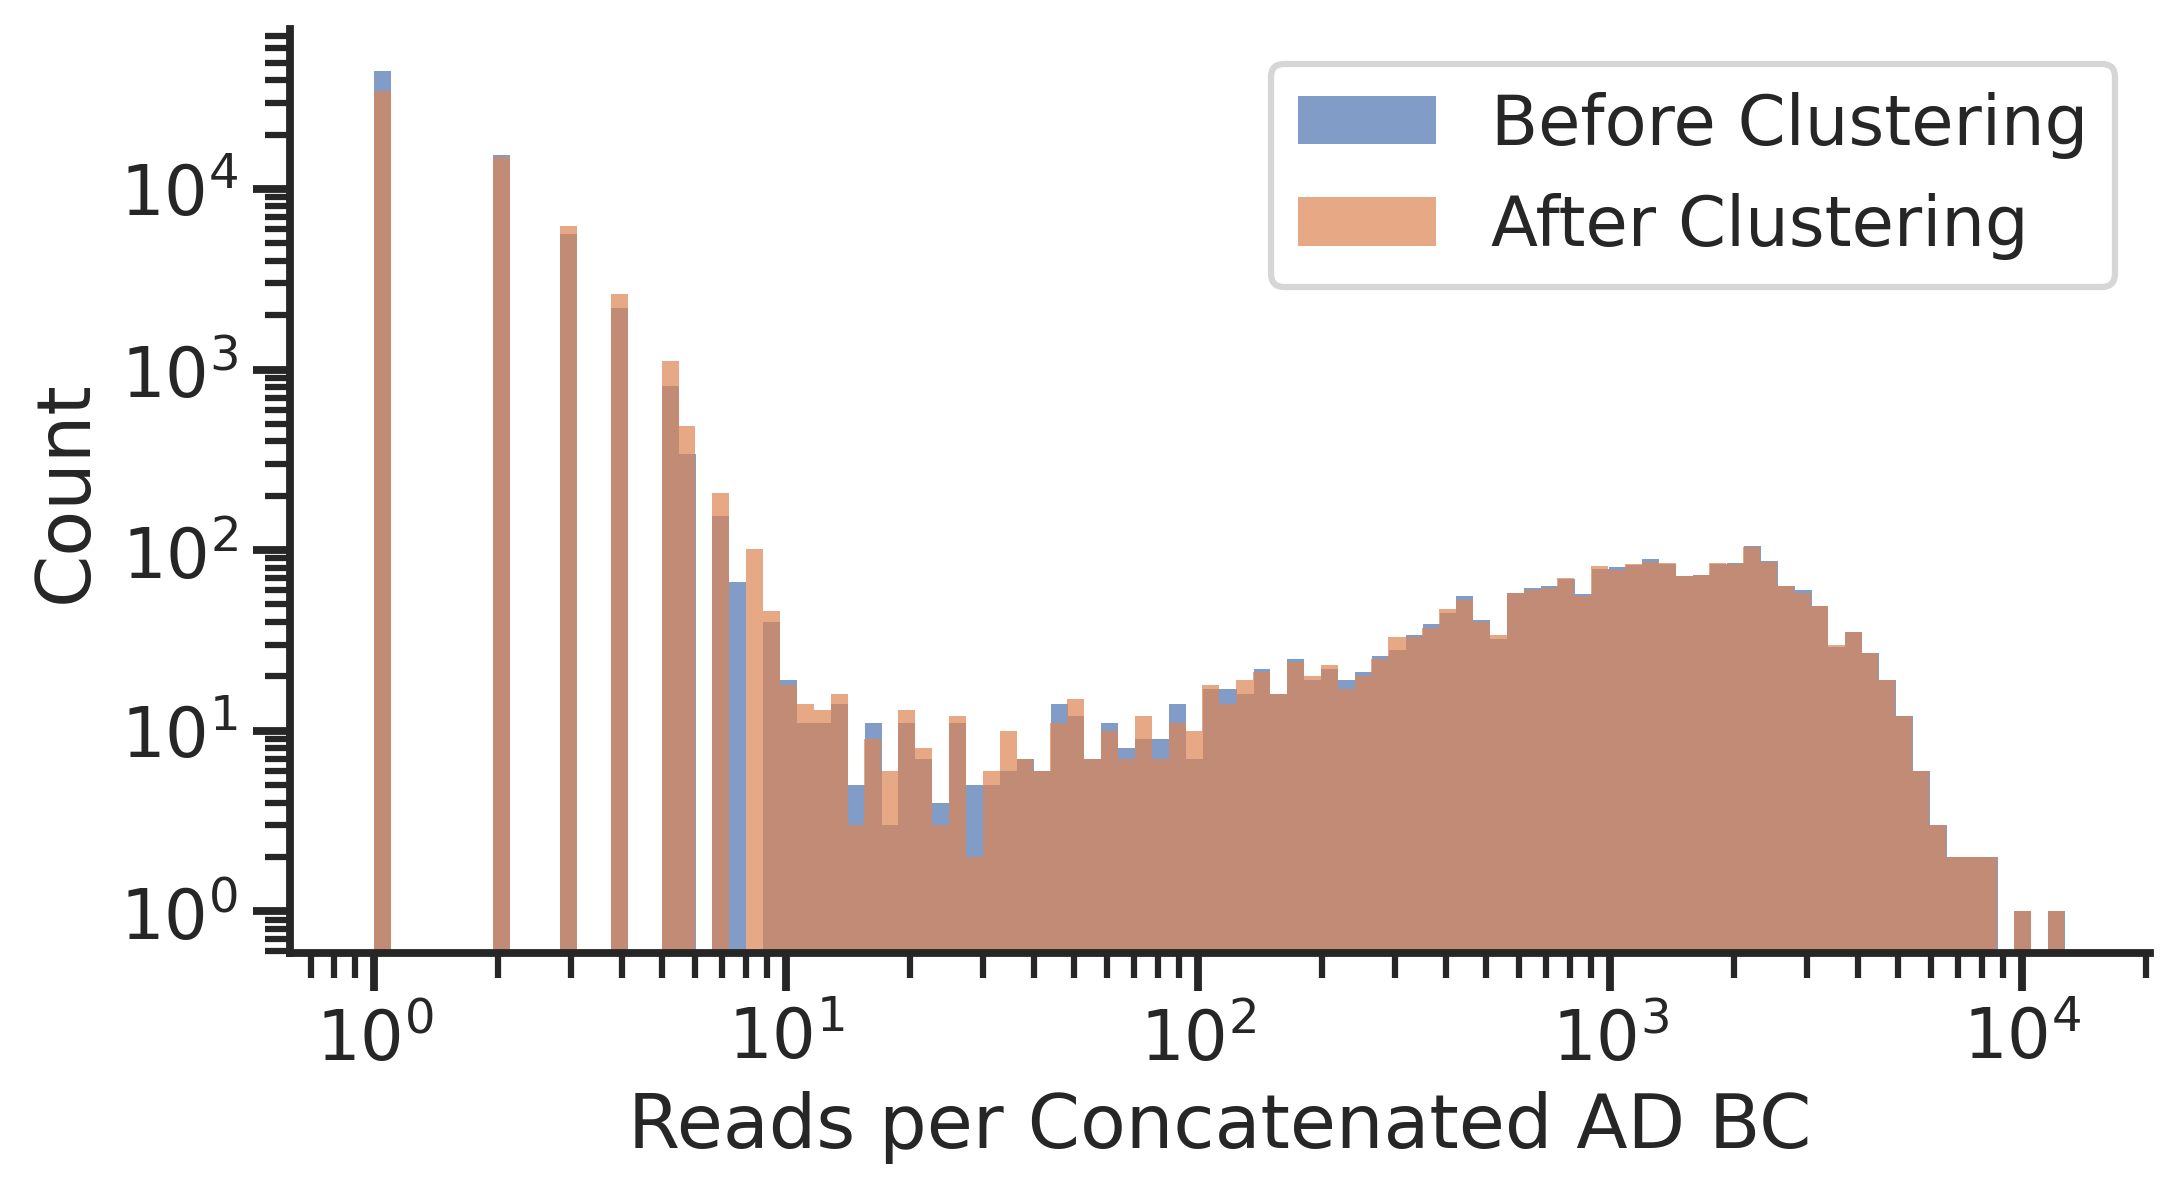

In [132]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["ADBC2", "HawkBCs"], ax = ax, label = "Before Clustering", step_name = "grouped")
#plot_summed_counts(refiner, ["ADBC2", "HawkBCs"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.legend()
ax.set_xlabel("Reads per Concatenated AD BC")

#plt.xlim(0,12.25)

sns.despine()

plt.show()

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["ADBC2", "HawkBCs"], ax = ax, label = "Before Clustering", step_name = "grouped")
plot_summed_counts(refiner, ["ADBC2", "HawkBCs"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.set_xlabel("Reads per Concatenated AD BC")

ax.legend()

#plt.xlim(0,12.25)

sns.despine()

3116634

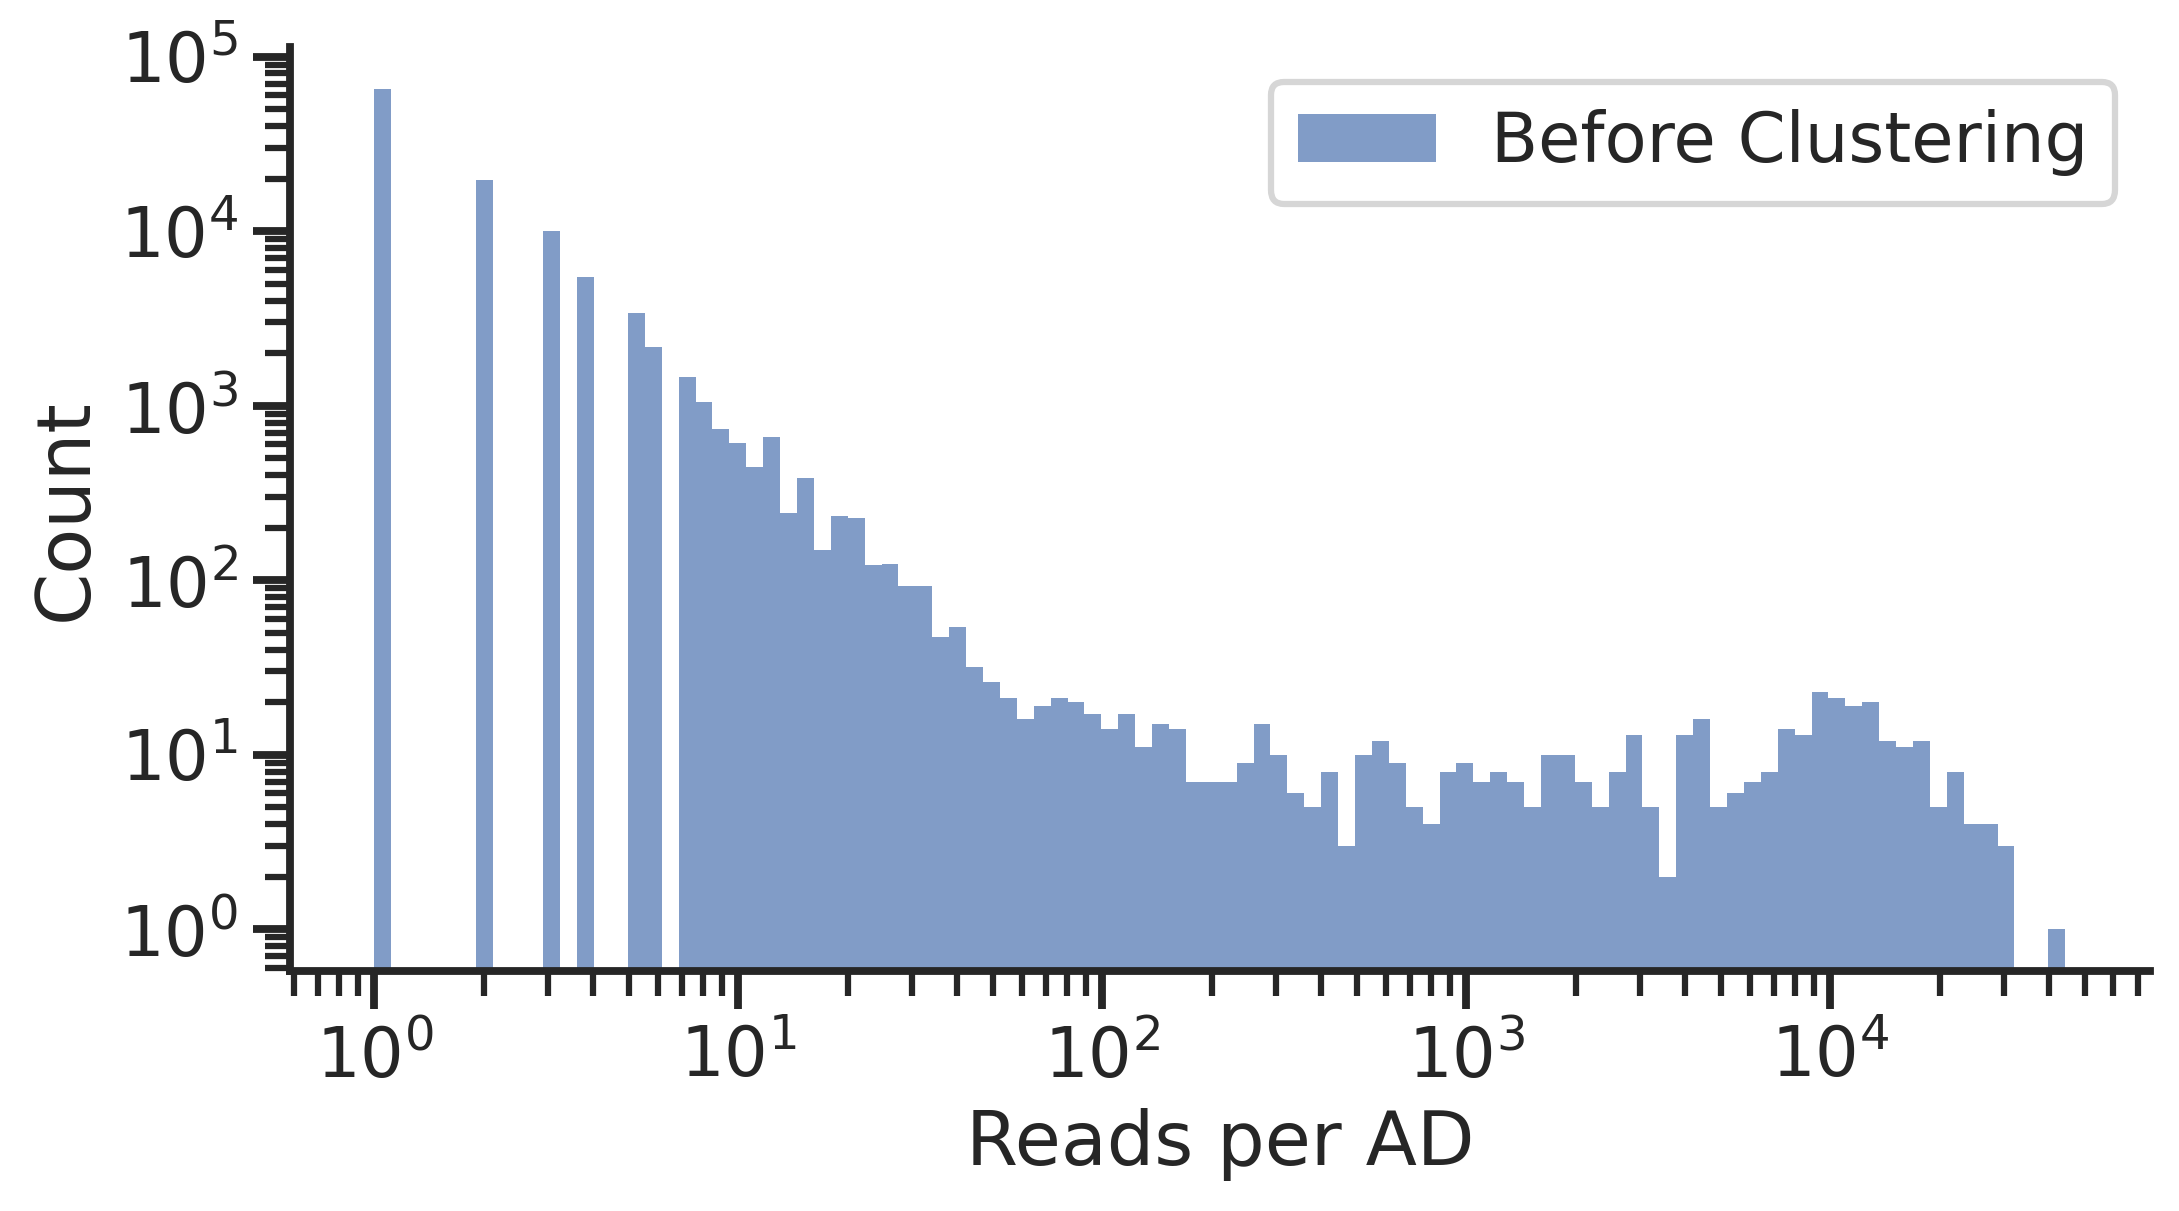

3116634

3089119

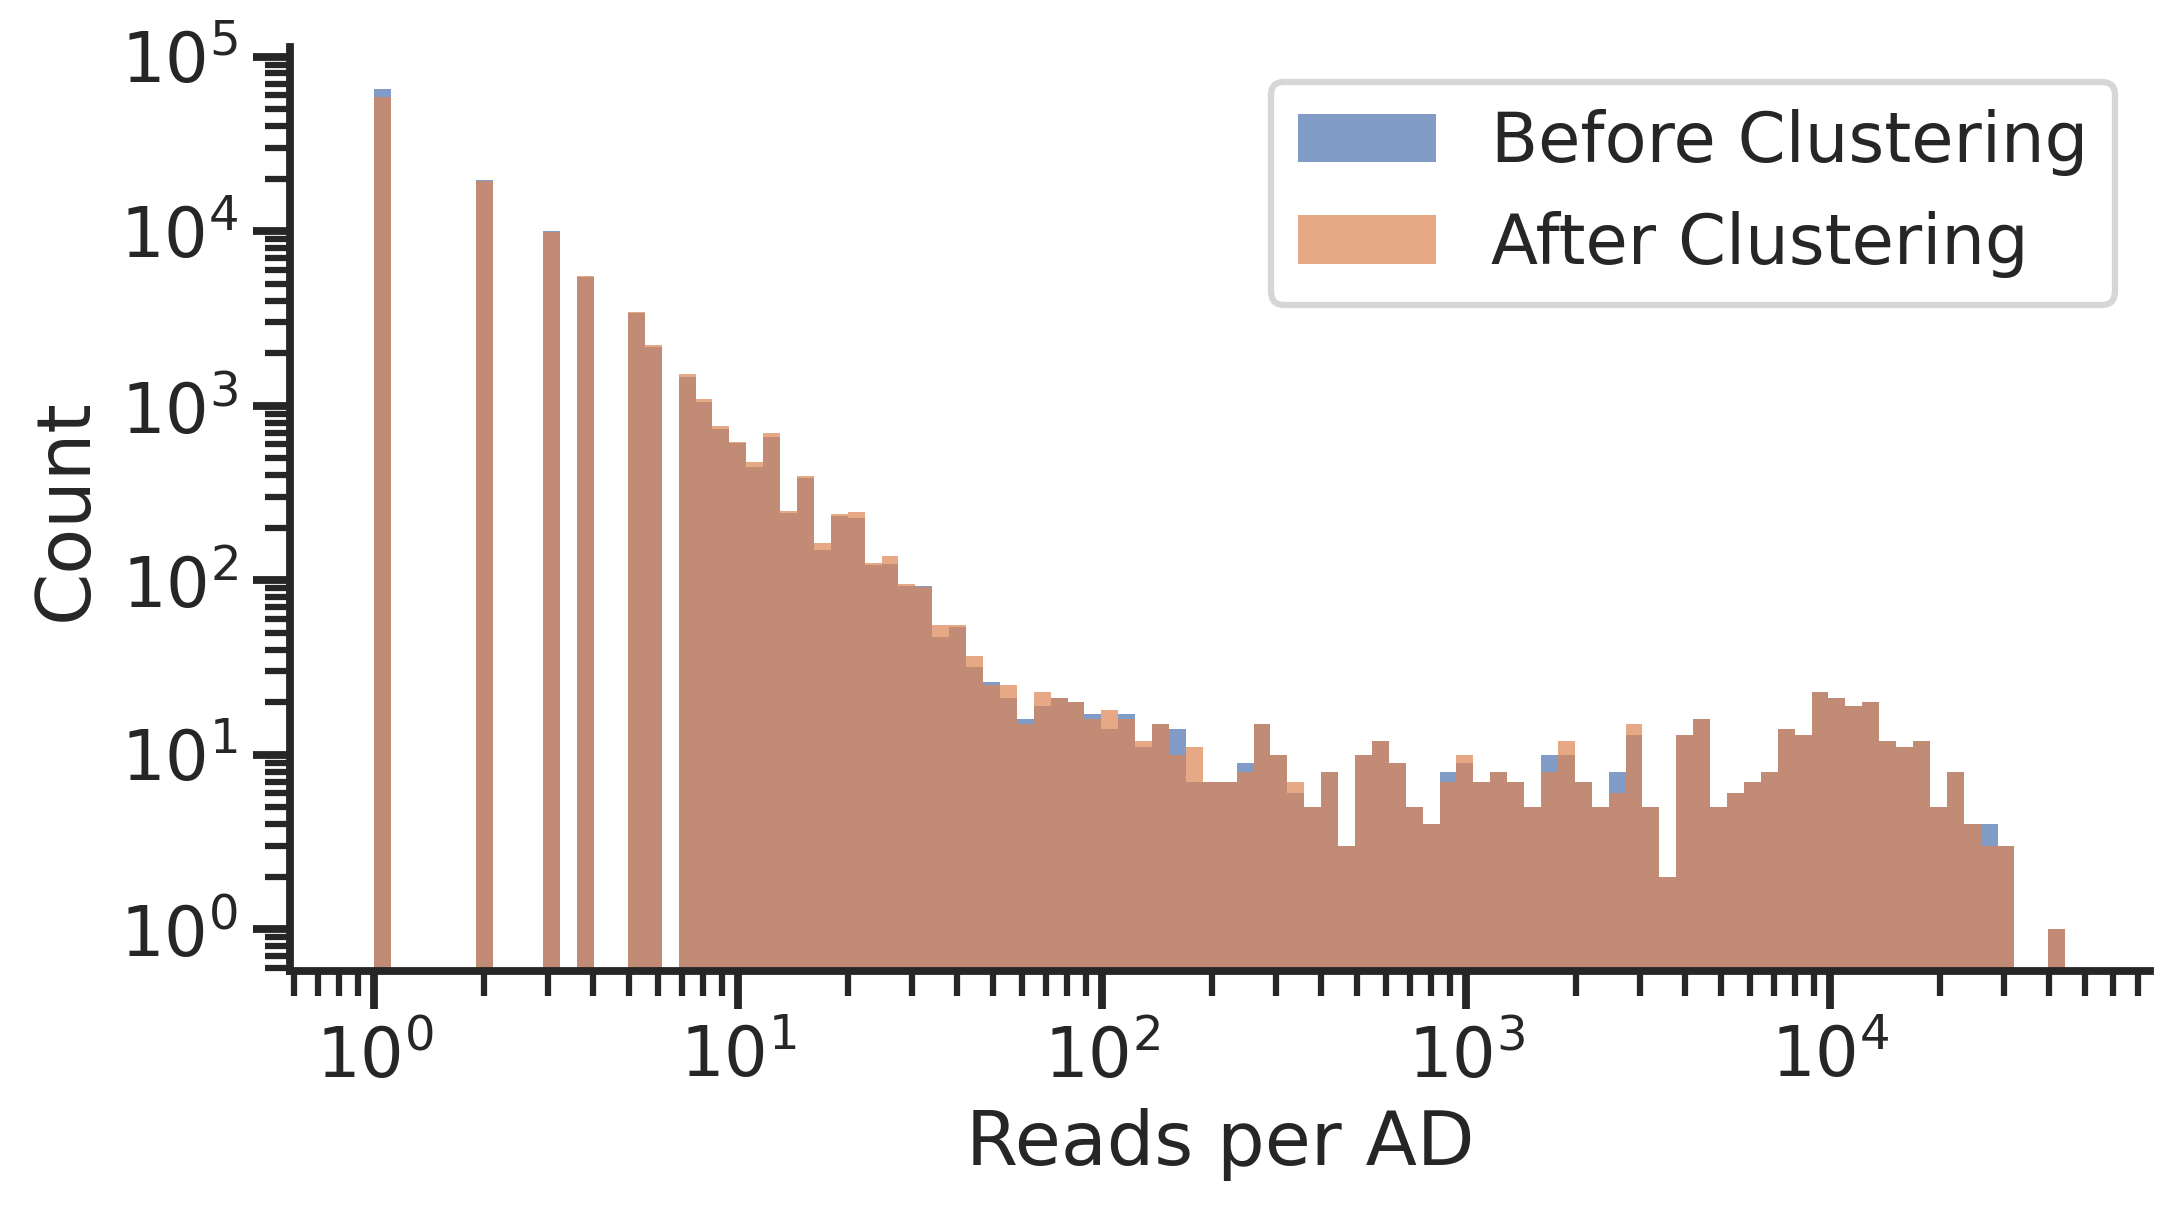

In [133]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["AD"], ax = ax, label = "Before Clustering", step_name = "grouped")
#plot_summed_counts(refiner, ["ADBC2", "HawkBCs"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.legend()
ax.set_xlabel("Reads per AD")

#plt.xlim(0,12.25)

sns.despine()

plt.show()

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["AD"], ax = ax, label = "Before Clustering", step_name = "grouped")
plot_summed_counts(refiner, ["AD"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.legend()
ax.set_xlabel("Reads per AD")

#plt.xlim(0,12.25)

sns.despine()

3116634

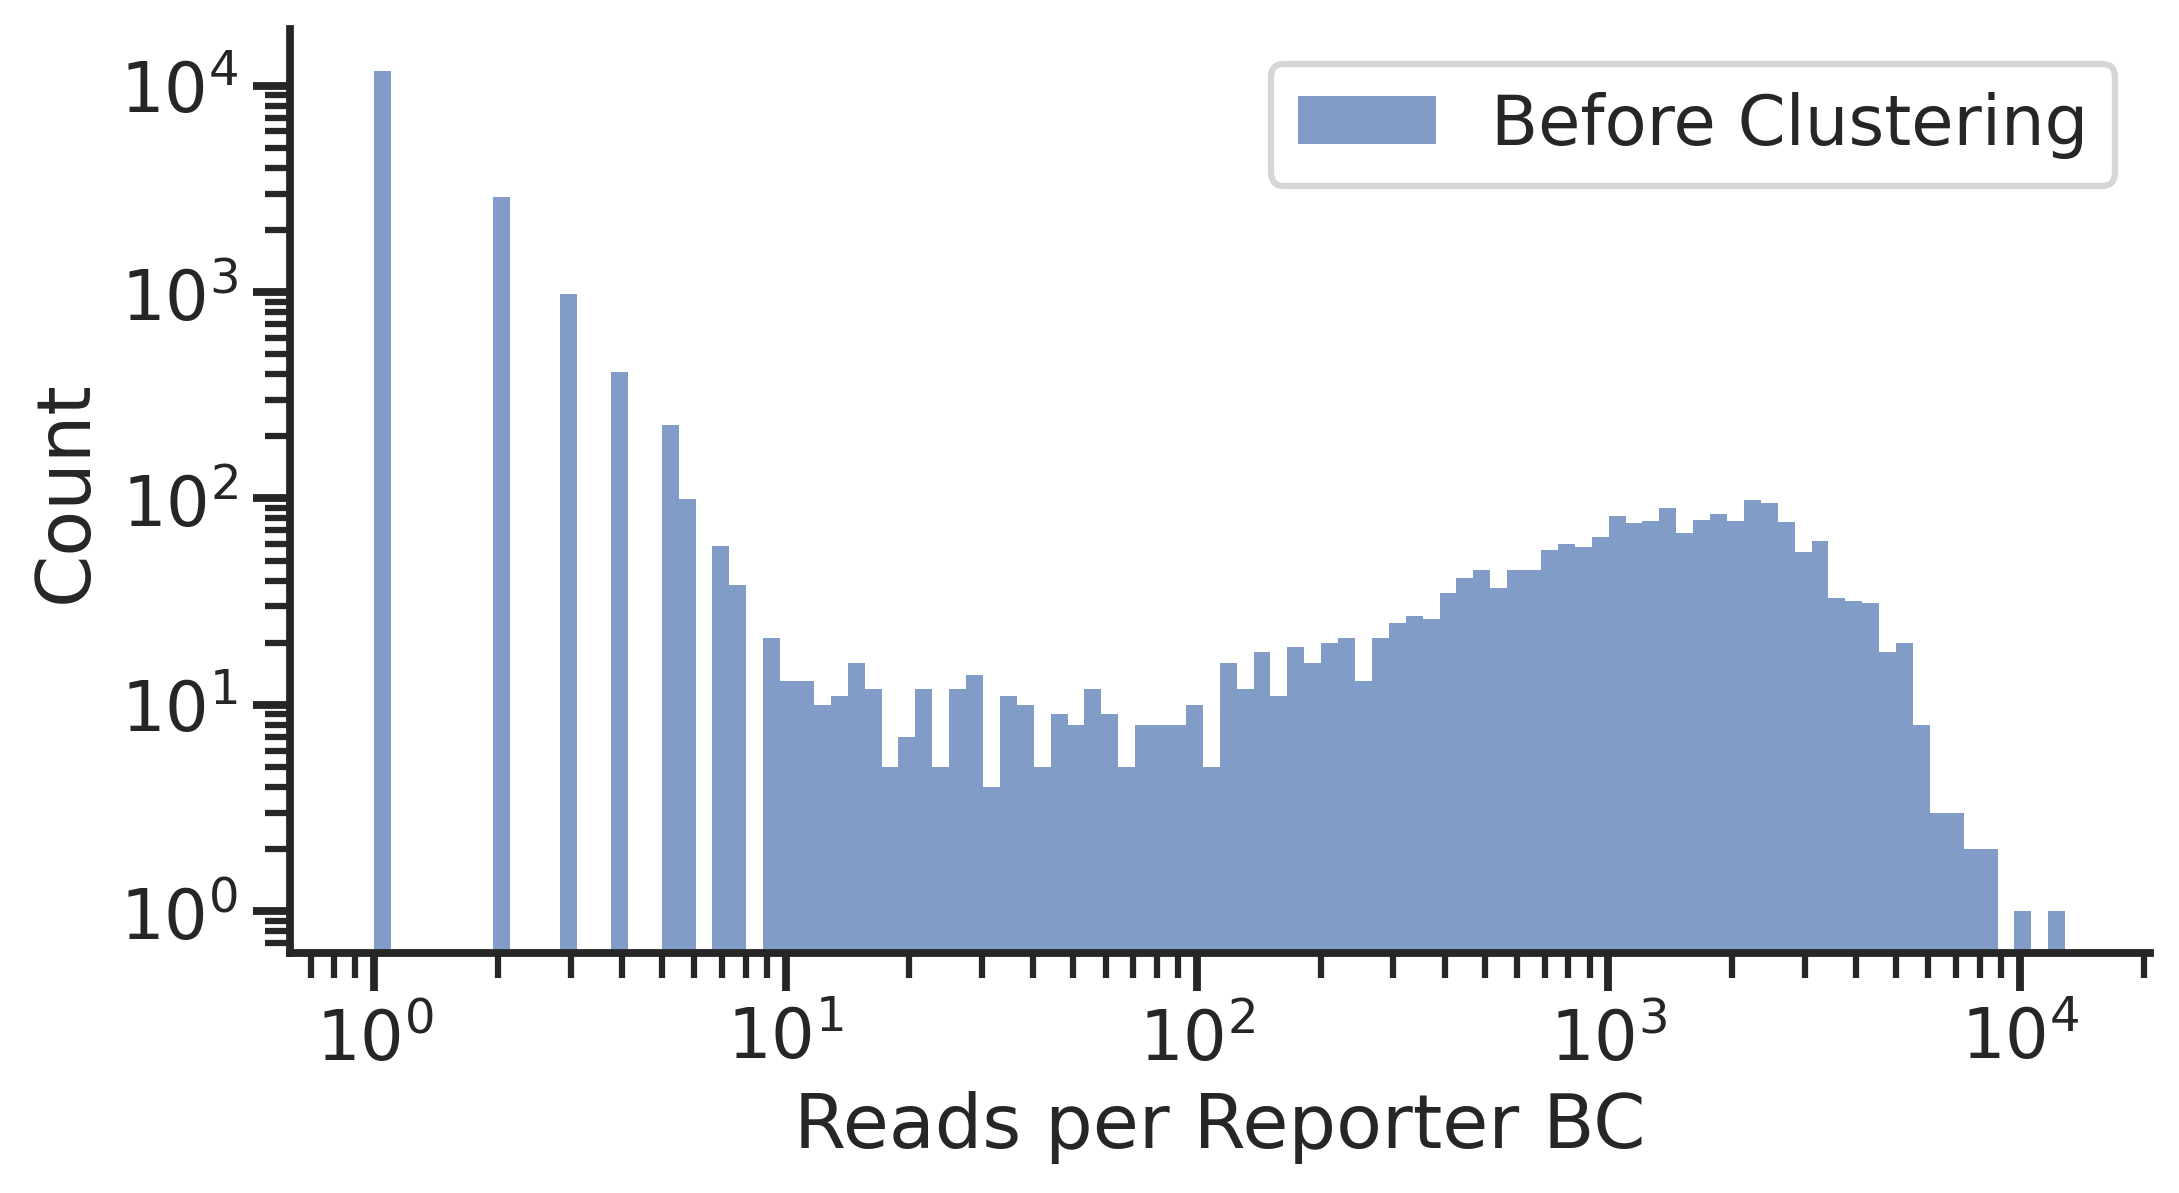

3116634

3089119

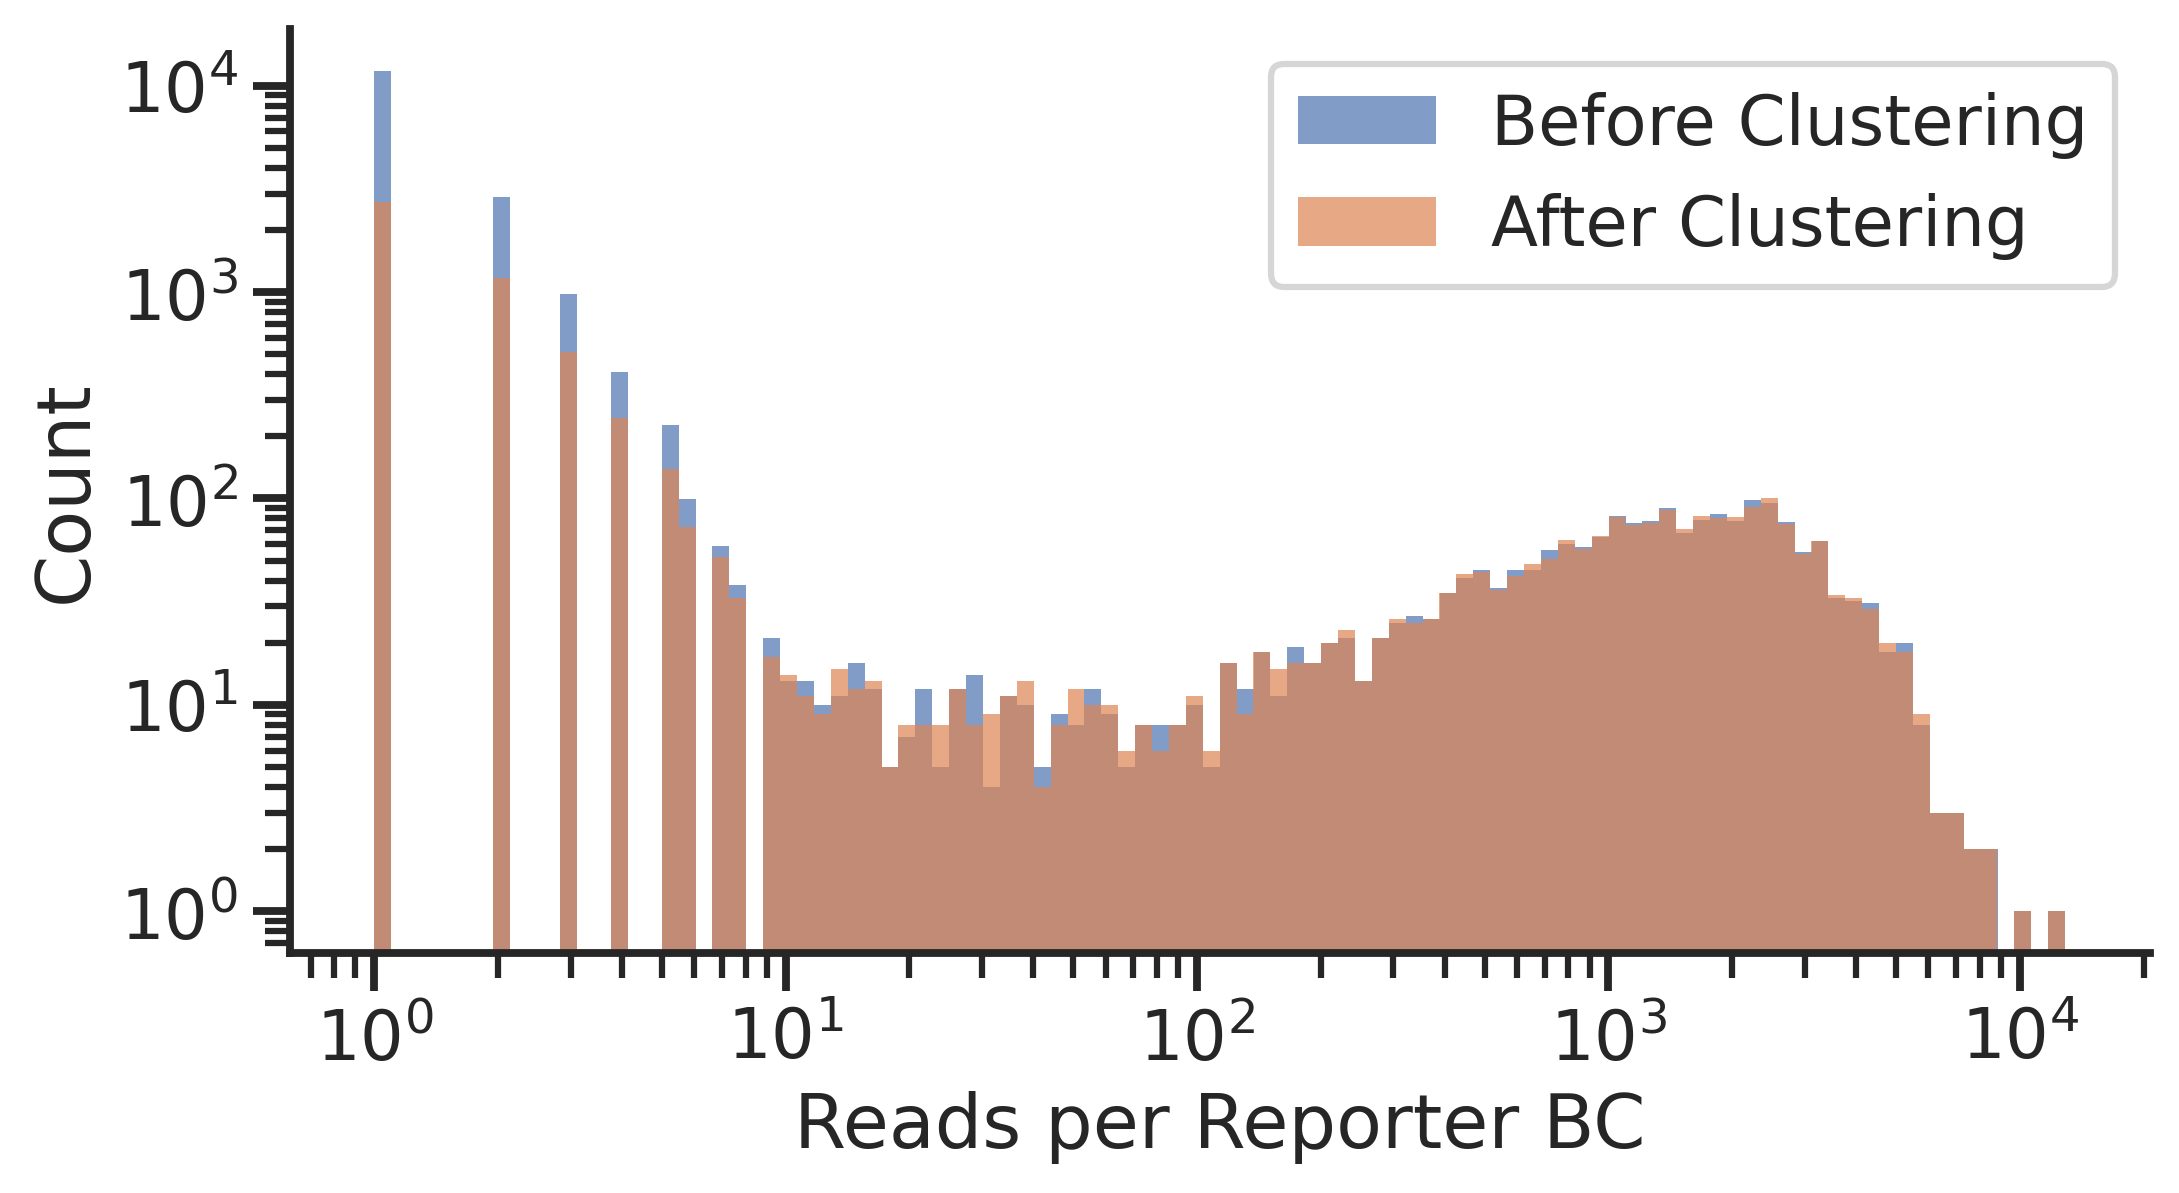

In [134]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["RTBC"], ax = ax, label = "Before Clustering", step_name = "grouped")
#plot_summed_counts(refiner, ["ADBC2", "HawkBCs"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.legend()
ax.set_xlabel("Reads per Reporter BC")

#plt.xlim(0,12.25)

sns.despine()

plt.show()

fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
plot_summed_counts(refiner_no_cluster, ["RTBC"], ax = ax, label = "Before Clustering", step_name = "grouped")
plot_summed_counts(refiner, ["RTBC"], ax = ax, label = "After Clustering", step_name = 'barcode_exists')
ax.legend()
ax.set_xlabel("Reads per Reporter BC")

#plt.xlim(0,12.25)

sns.despine()

In [150]:
def plot_ad_rtb_counts(refiner, label=None, ax=None, add_counts=False):
    """
    Plots a histogram of counts per concatenated ADBCs per AD with counts on top of bars.

    Parameters
    ----------
    refiner : MapRefiner
        The MapRefiner instance containing the 'quality_designed' table.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure and axis will be created.
    """
    

    # Get quality_designed dataframe
    quality_designed = refiner.get_map_df('quality_designed')
    quality_designed["concat_ADBCs"] = quality_designed["ADBC2"] + quality_designed["HawkBCs"]
    
    # Compute counts per AD-RTBC combination
    counts = quality_designed.groupby(["concat_ADBCs", "RTBC"]).size().reset_index(name="count")

    # Create figure if ax not provided
    if ax is None:
        plt.figure(figsize=(6,4))
        ax = plt.gca()
    
    # Plot histogram
    sns.histplot(data=counts, x="count", discrete=True, ax=ax, label = label)

    if add_counts:
        # Add counts on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0 and height <= 10:
                ax.text(
                    p.get_x() + p.get_width()/2,
                    height + 0.05,
                    int(height),
                    ha='center', va='bottom'
                )

    # Make x-axis ticks discrete
    max_count = counts["count"].max()
    ax.set_xticks(np.arange(1, max_count + 1, 1))
    ax.set_xlim(0.5, None)
    
    ax.set_xlabel("Unique concatenated ADBCs per AD")
    ax.set_ylabel("Frequency")
    sns.despine()
    
    return ax

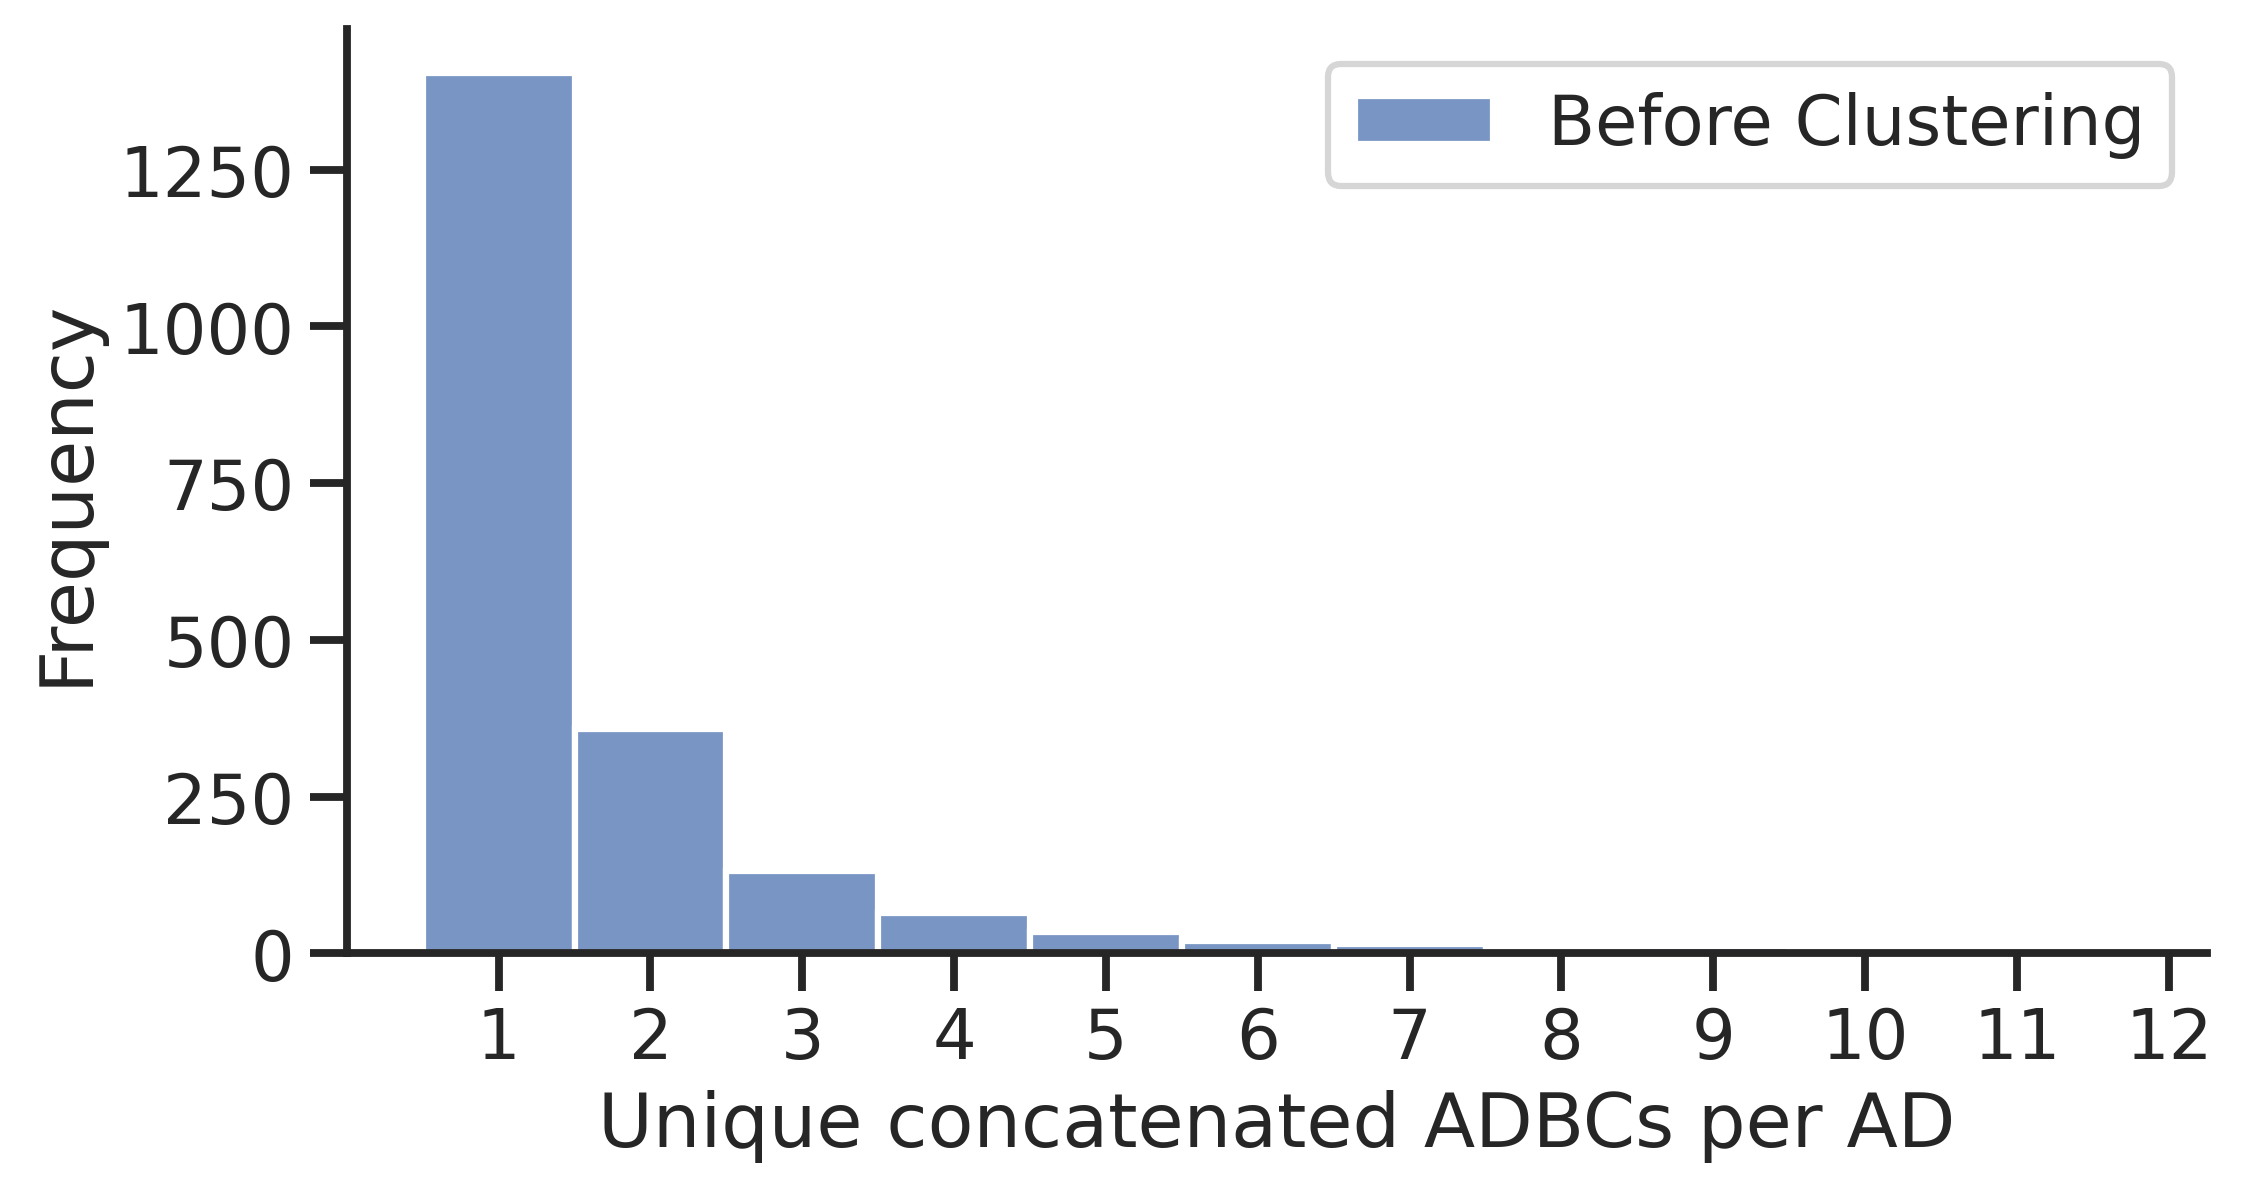

In [151]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300, sharex = True)
plot_ad_rtb_counts(refiner_no_cluster, ax = ax, label = "Before Clustering")
#plot_ad_rtb_counts(refiner, ax = ax, label = "After Clustering")
ax.legend()

plt.xlim(0,12.25)

sns.despine()

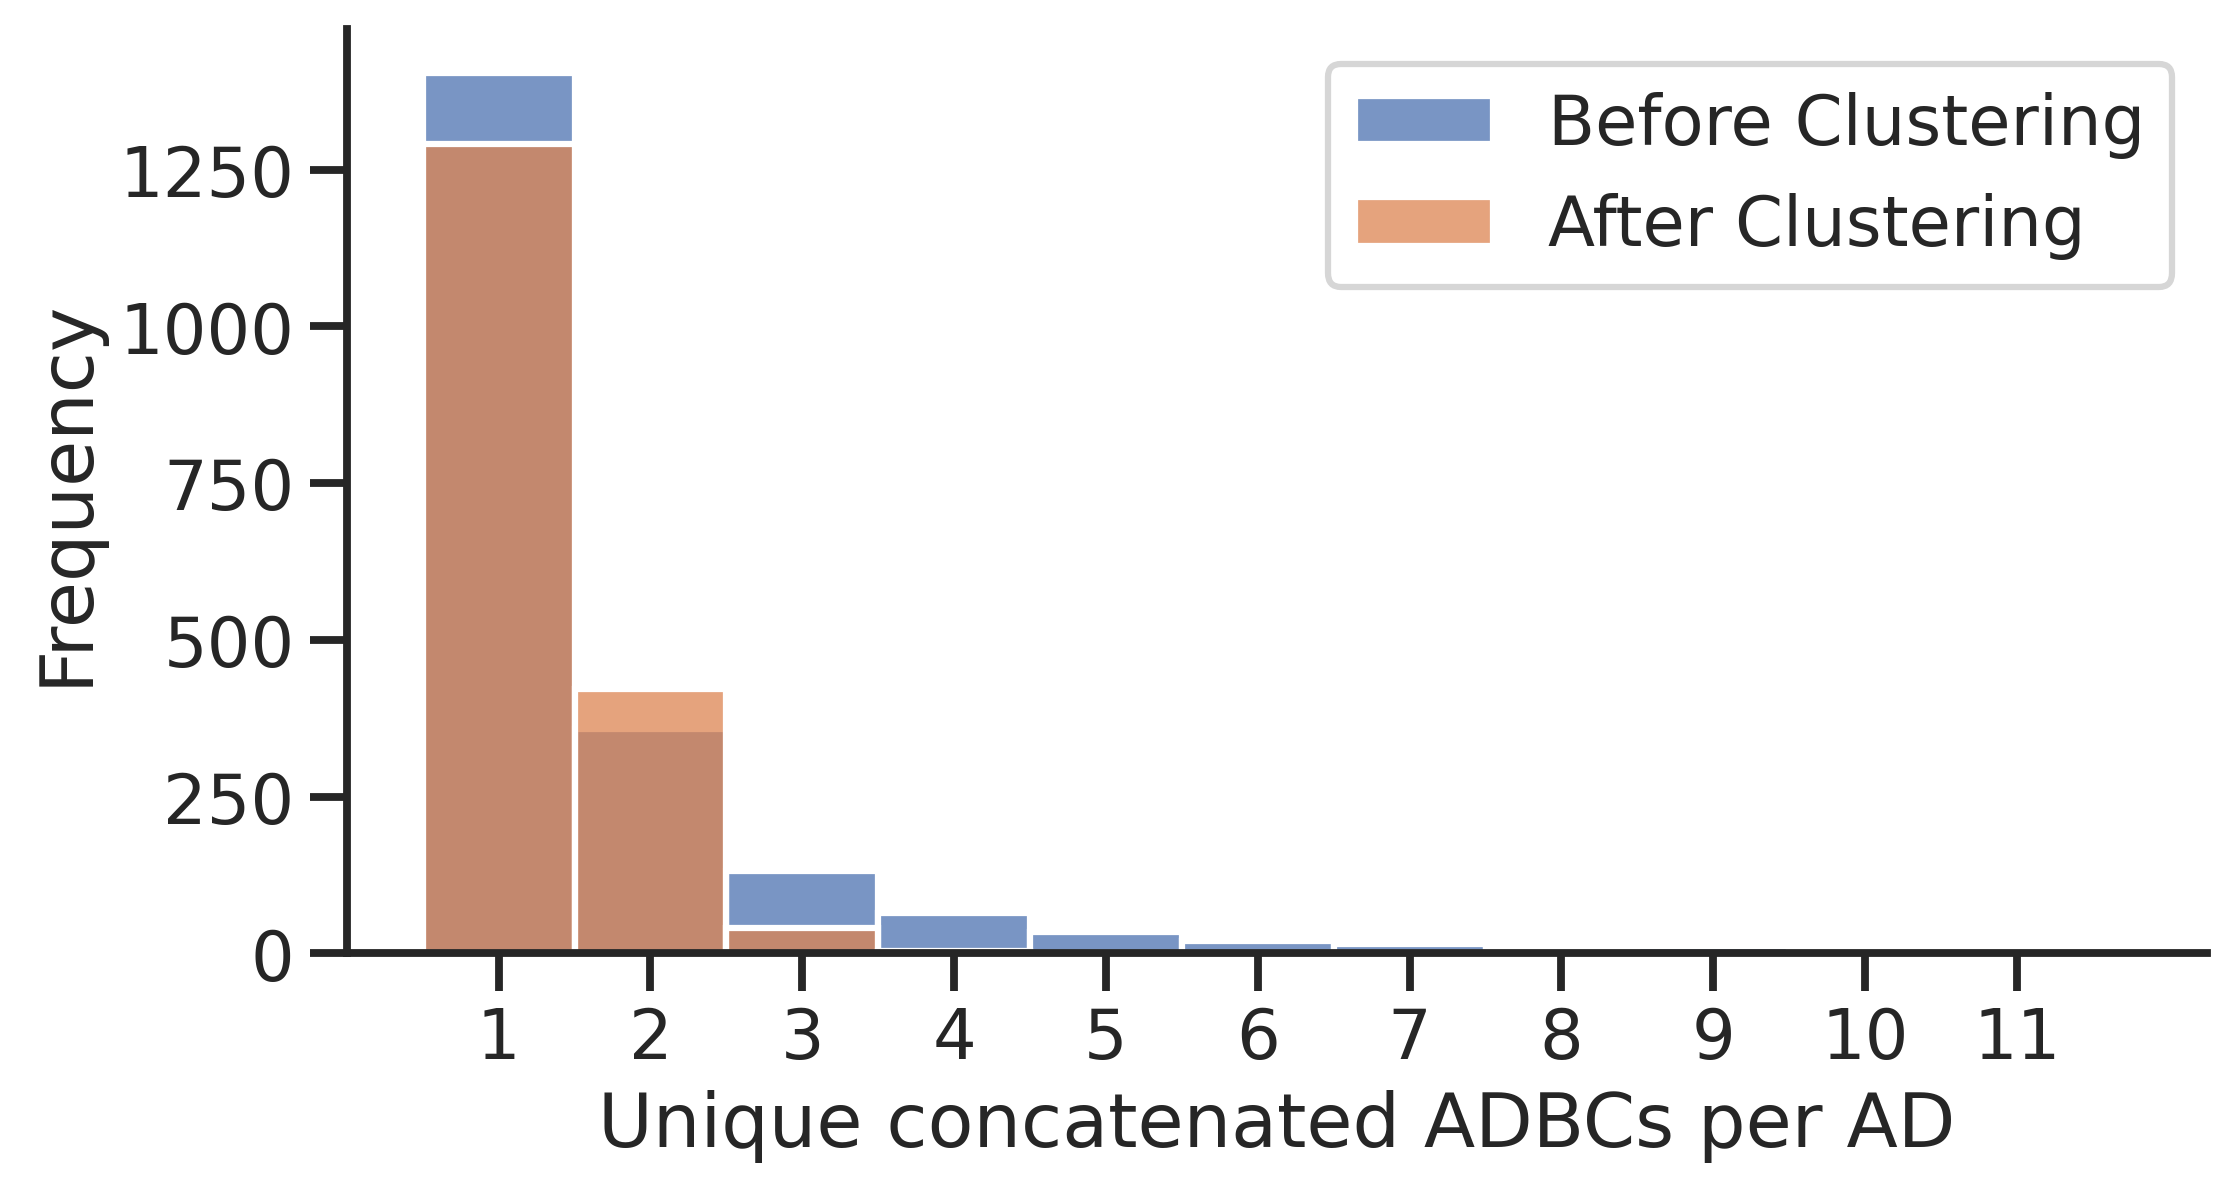

In [152]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300, sharex = True)
plot_ad_rtb_counts(refiner_no_cluster, ax = ax, label = "Before Clustering")
plot_ad_rtb_counts(refiner, ax = ax, label = "After Clustering")
ax.legend()

plt.xlim(0,12.25)

sns.despine()

In [162]:
def plot_rtbc_per_ad(refiner, ax=None, label=None, add_counts=False):
    """
    Plots a histogram of the number of unique RTBCs per AD with counts on top of bars.

    Parameters
    ----------
    refiner : MapRefiner
        The MapRefiner instance containing the 'quality_designed' table.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure and axis will be created.
    """
    sns.set_style('ticks')

    # Compute counts per AD-RTBC combination
    counts = refiner.get_map_df('quality_designed').groupby(["AD", "RTBC"]).size().reset_index(name="count")

    # Create figure if ax not provided
    if ax is None:
        plt.figure(figsize=(6,4))
        ax = plt.gca()

    # Plot histogram
    sns.histplot(data=counts, x="count", discrete=True, ax=ax, label=label)

    if add_counts:
        # Add counts on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(
                    p.get_x() + p.get_width()/2,
                    height,
                    int(height),
                    ha='center', va='bottom'
                )

    # Make x-axis ticks discrete
    max_count = counts["count"].max()
    ax.set_xticks(np.arange(0, max_count + 1, 1))
    ax.set_xlim(0.25, None)
    ax.set_xlabel("Unique RTBCs per AD")
    ax.set_ylabel("Frequency")
    sns.despine()
    
    return ax


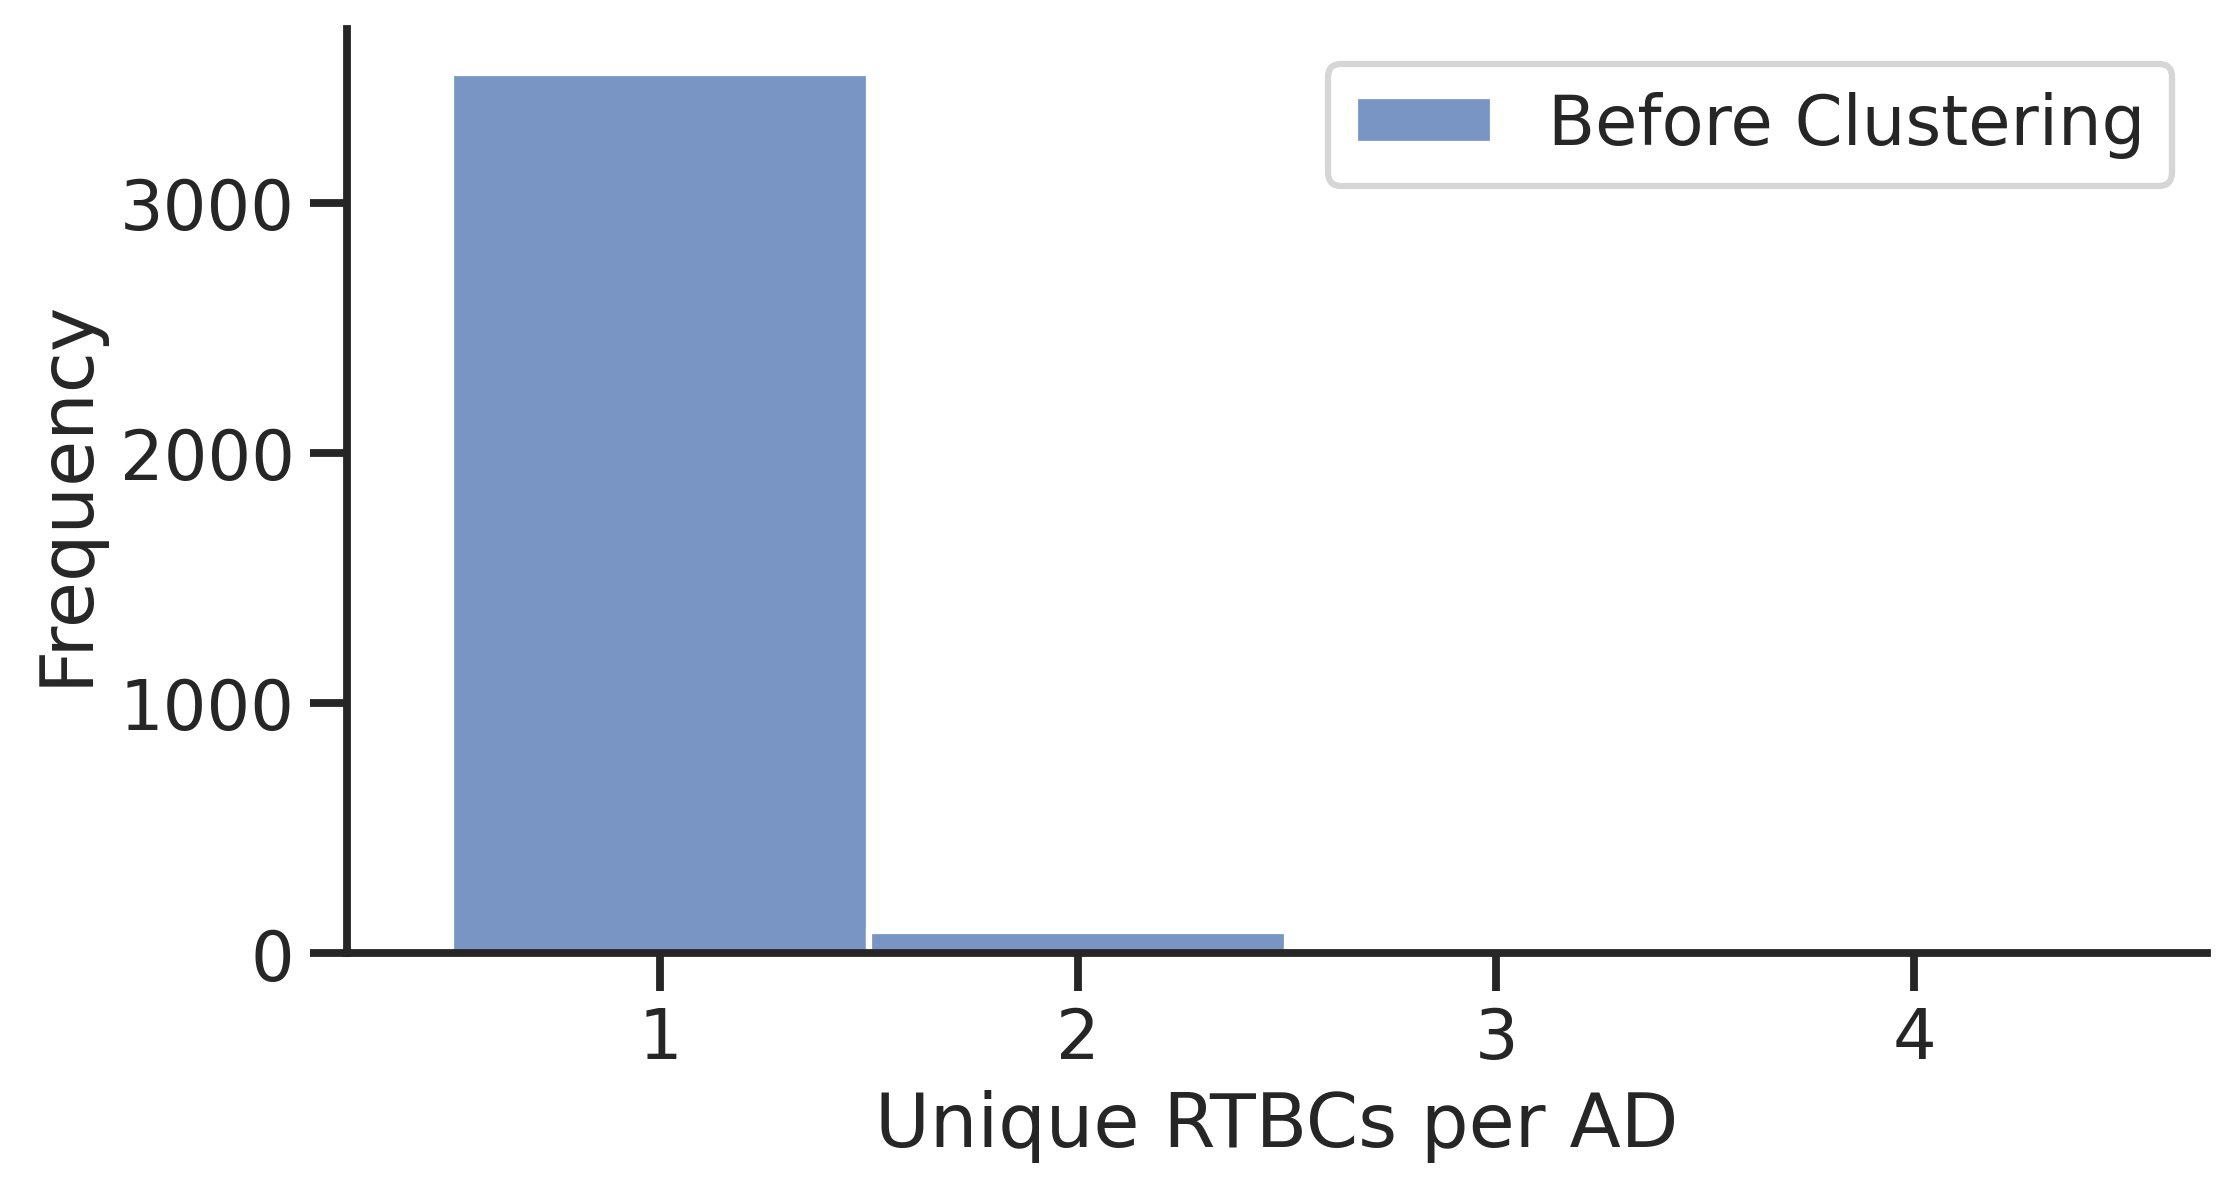

In [166]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300, sharex = True)
plot_rtbc_per_ad(refiner_no_cluster, ax = ax, label = "Before Clustering")
#plot_rtbc_per_ad(refiner, ax = ax, label = "After Clustering")
ax.legend()

# Make x-axis ticks discrete
max_count = 4
ax.set_xticks(np.arange(0, max_count + 1, 1))
ax.set_xlim(0.25, None)

sns.despine()

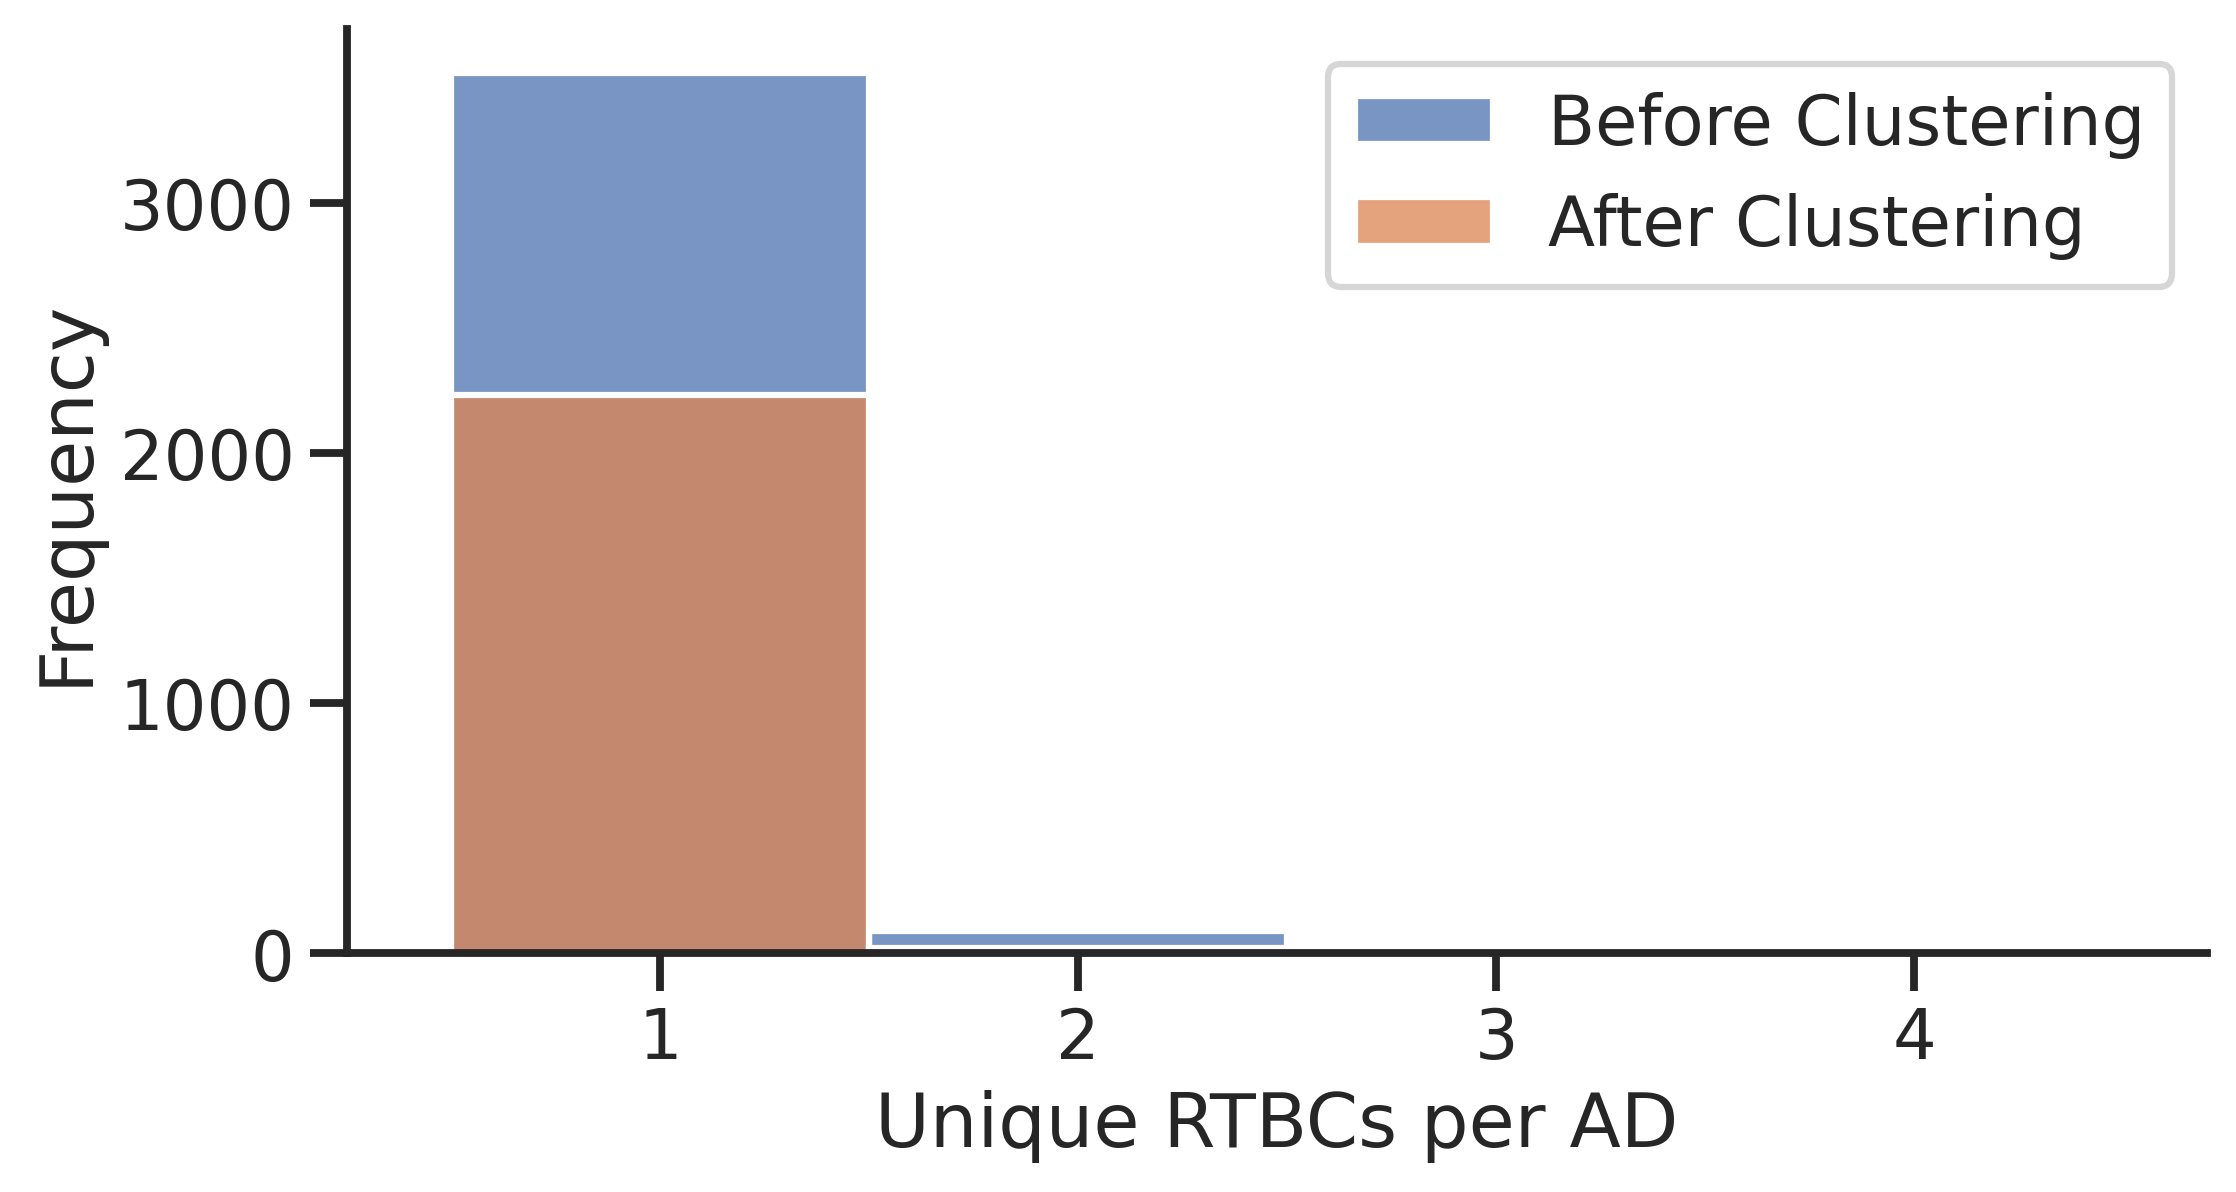

In [169]:
sns.set_context('talk')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (8,4), dpi = 300, sharex = True)
plot_rtbc_per_ad(refiner_no_cluster, ax = ax, label = "Before Clustering")
plot_rtbc_per_ad(refiner, ax = ax, label = "After Clustering")
ax.legend()

# Make x-axis ticks discrete
max_count = 4
ax.set_xticks(np.arange(0, max_count + 1, 1))
ax.set_xlim(0.25, None)

sns.despine()